In [1]:
#Training the model on 30k datasets.

import random
import numpy as np
from Bio import SeqIO
import gzip
import os
import pickle
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

#Set random seeds for reproducibility.
np.random.seed(4)
random.seed(5)
set_random_seed(4) 



def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X


Using TensorFlow backend.


1_PARCLIP_AGO1234_hg19


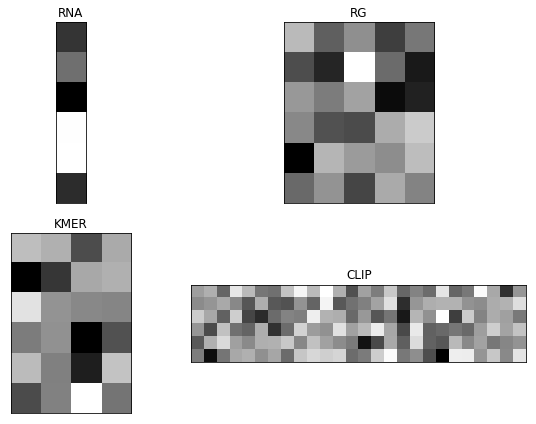

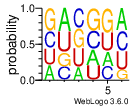

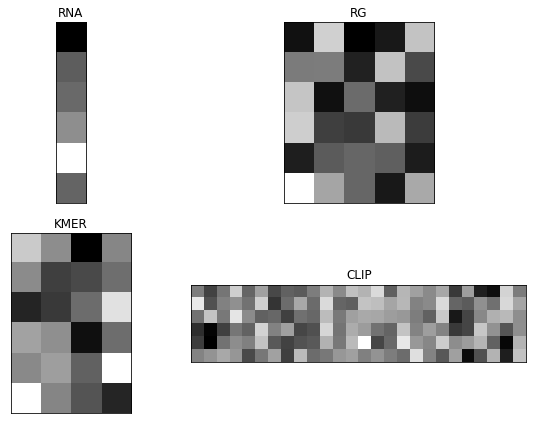

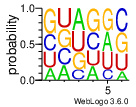

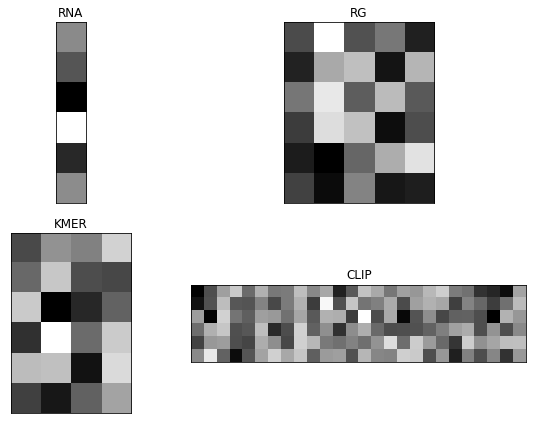

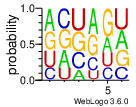

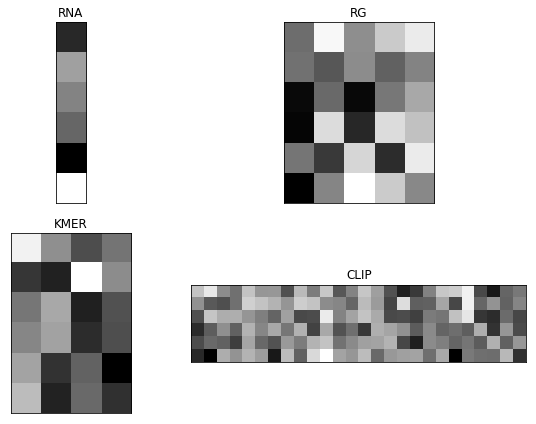

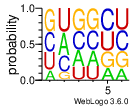

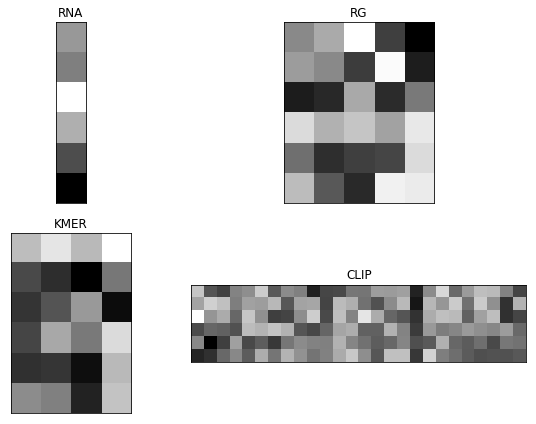

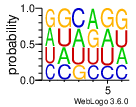

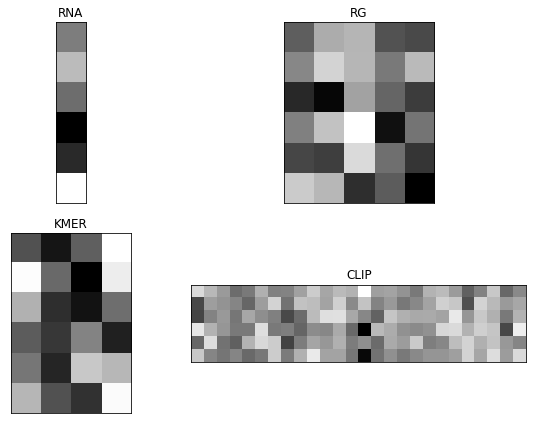

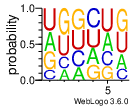

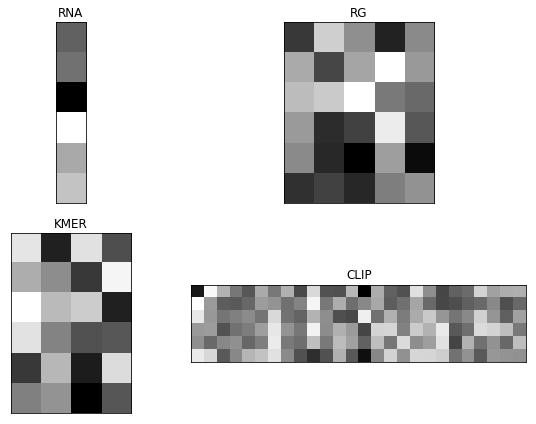

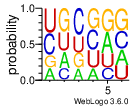

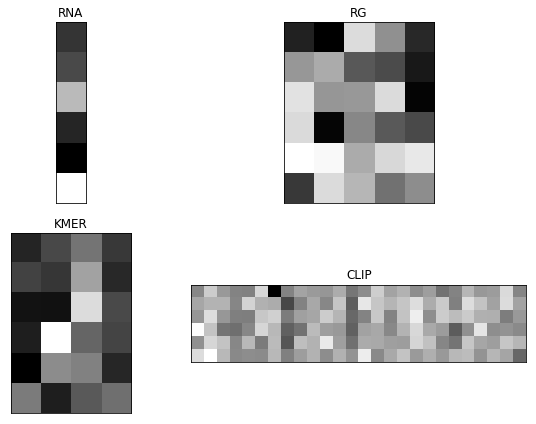

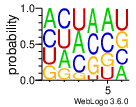

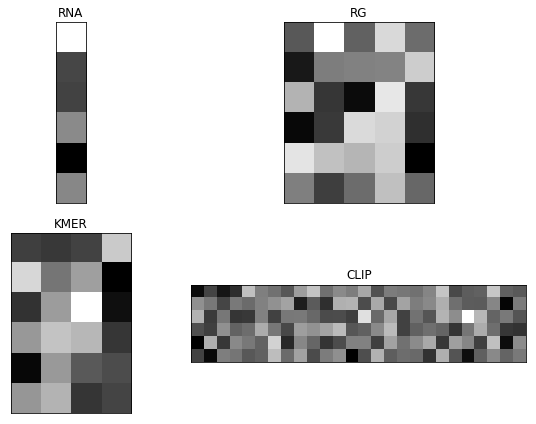

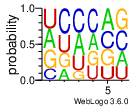

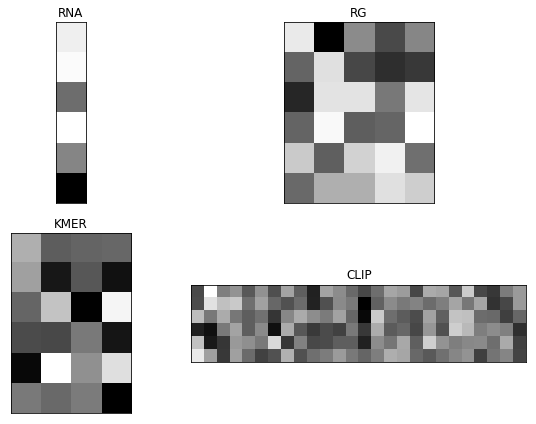

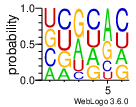

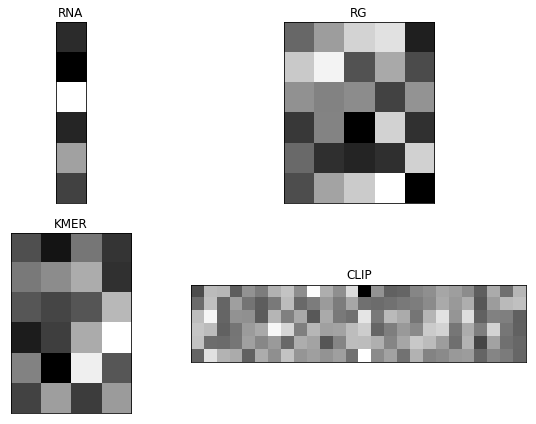

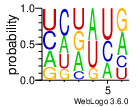

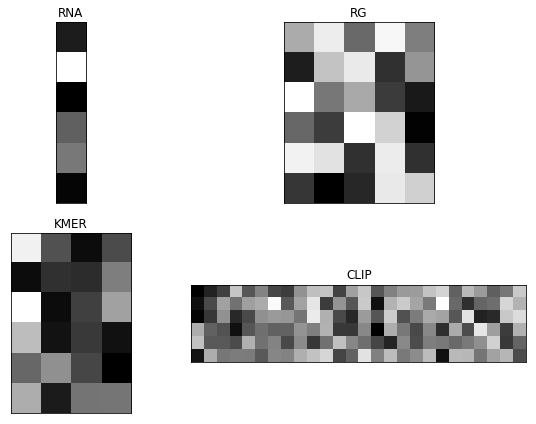

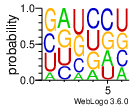

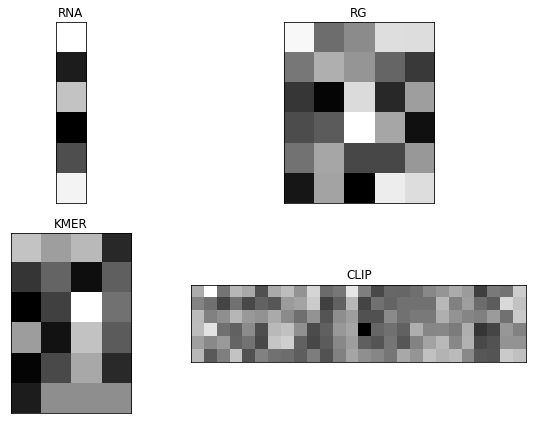

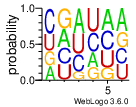

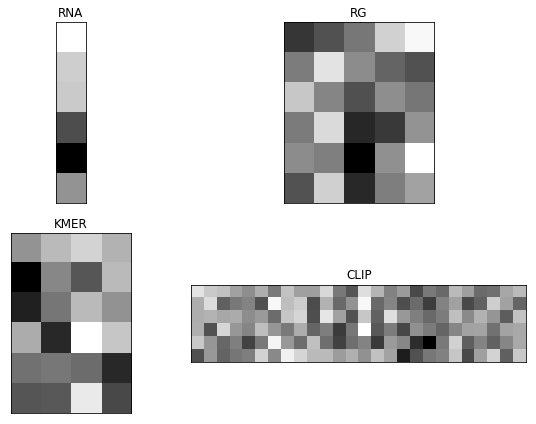

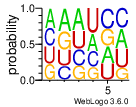

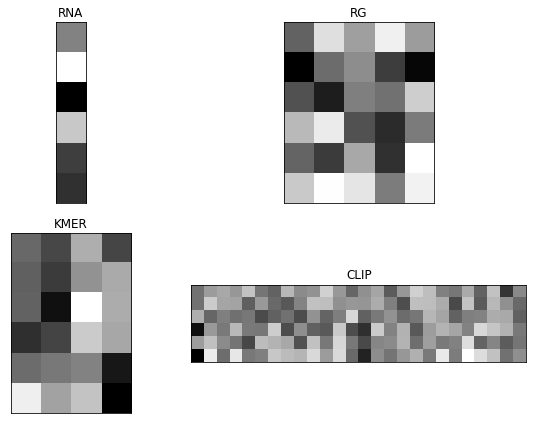

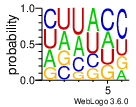

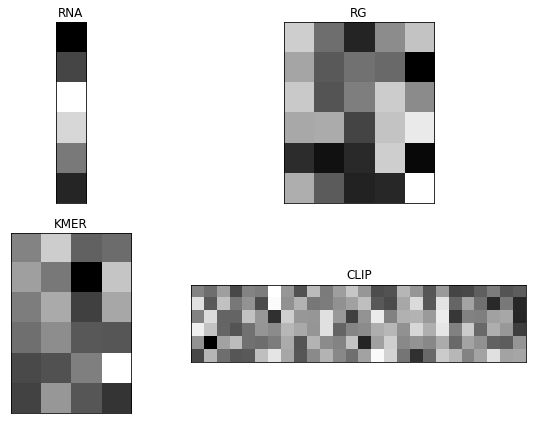

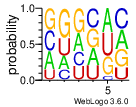

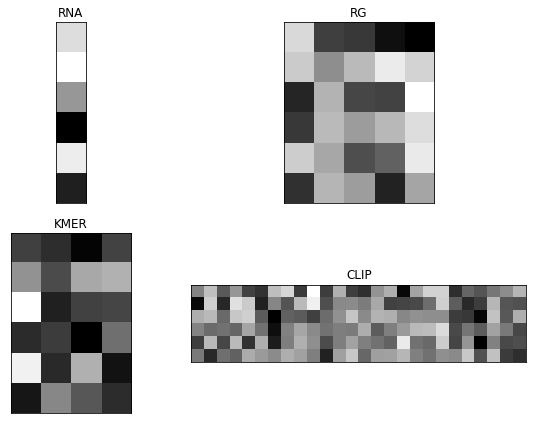

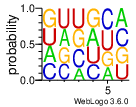

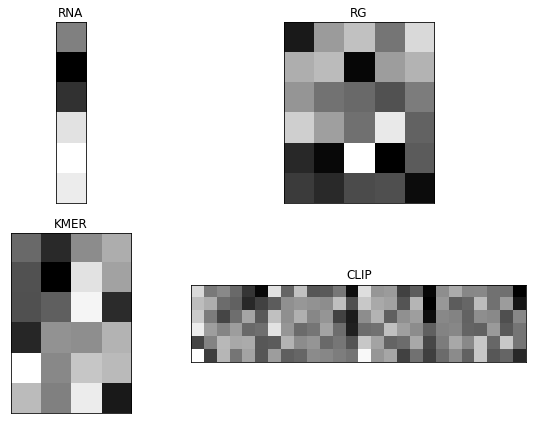

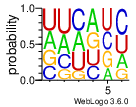

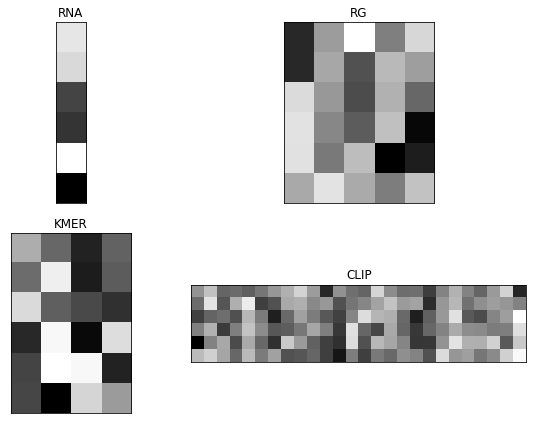

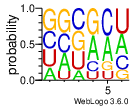

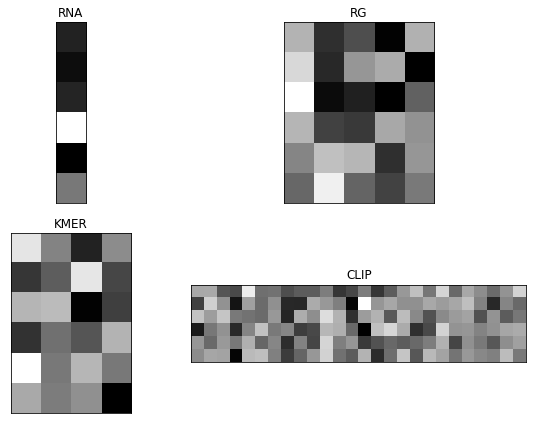

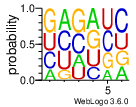

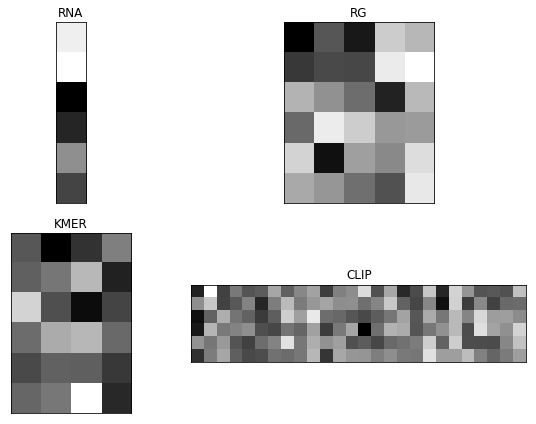

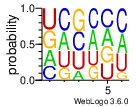

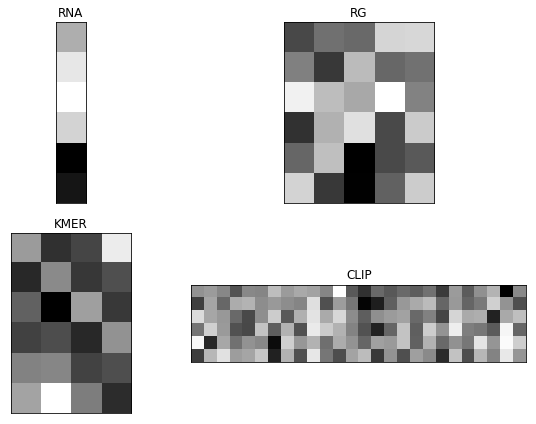

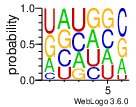

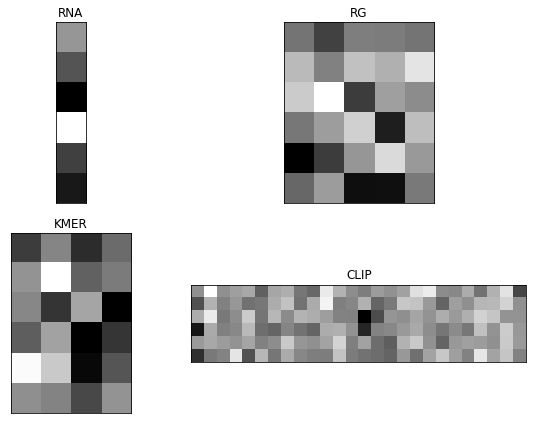

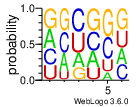

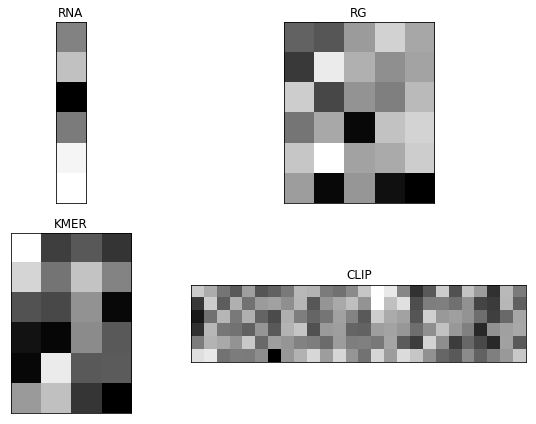

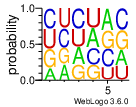

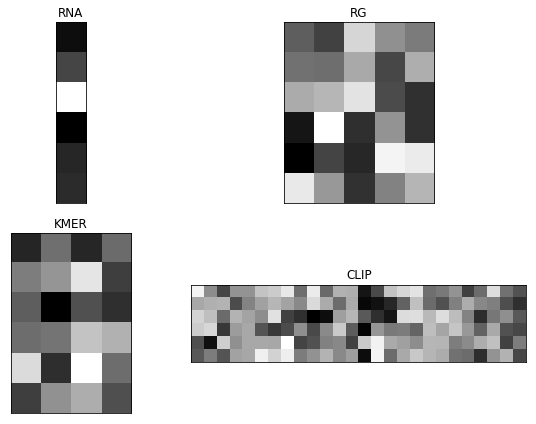

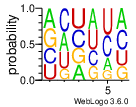

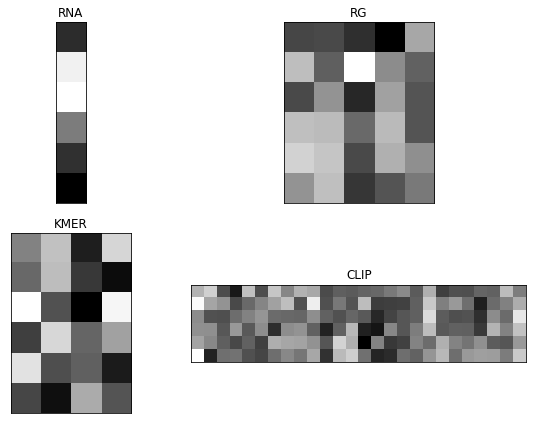

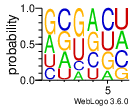

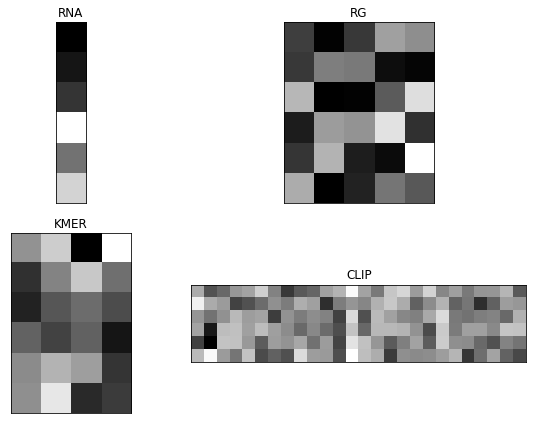

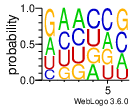

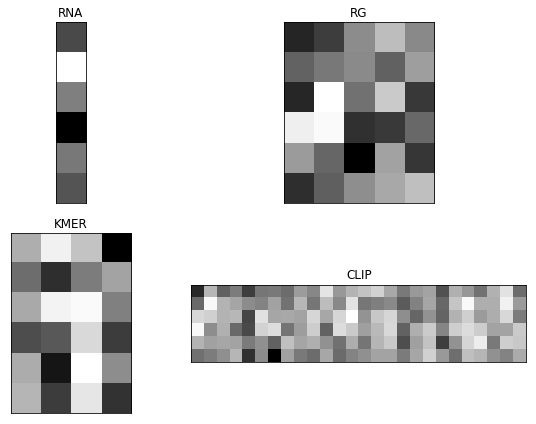

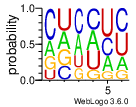

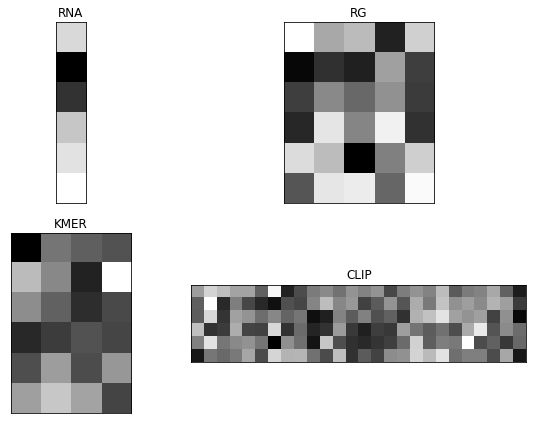

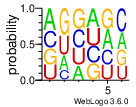

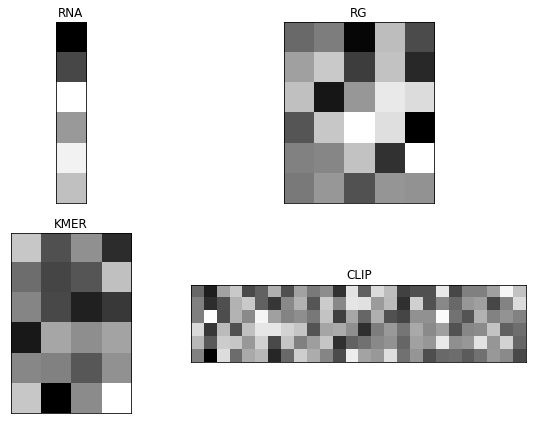

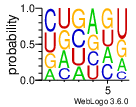

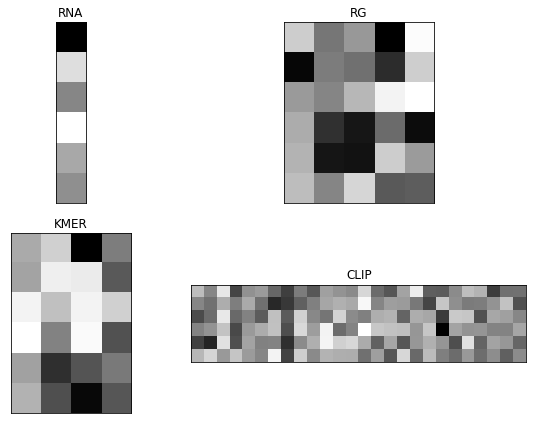

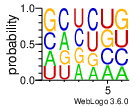

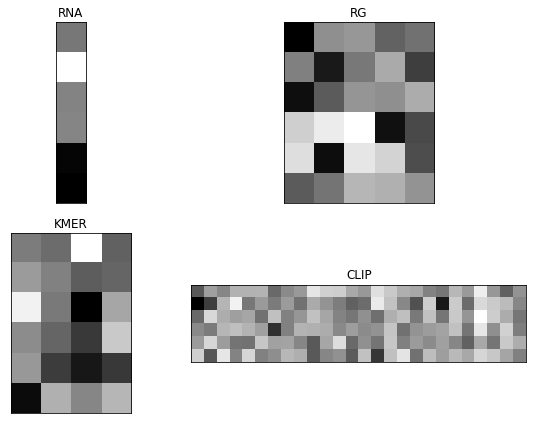

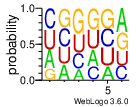

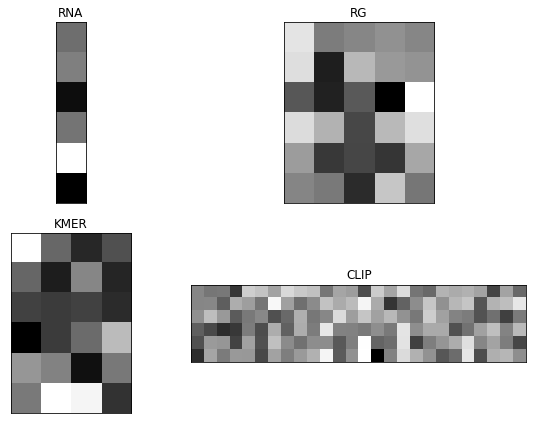

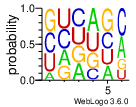

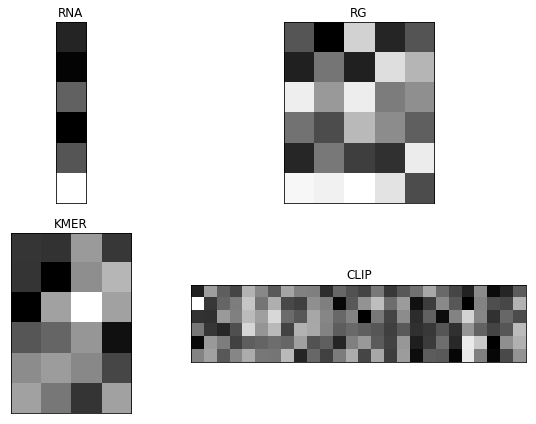

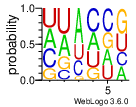

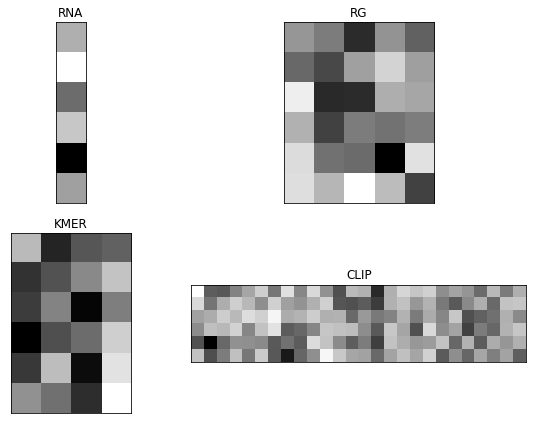

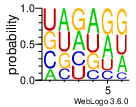

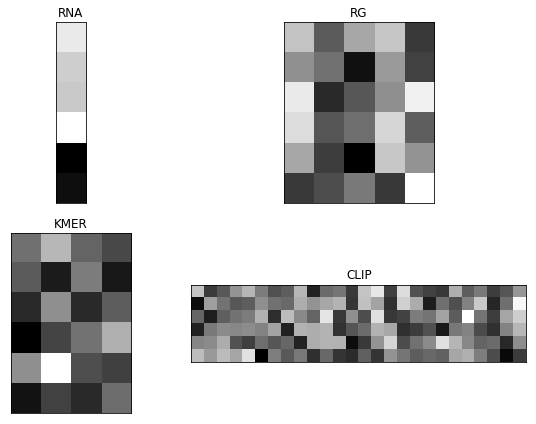

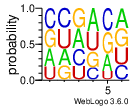

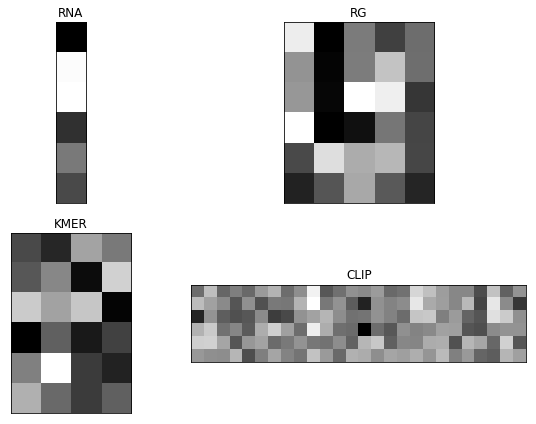

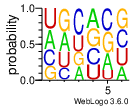

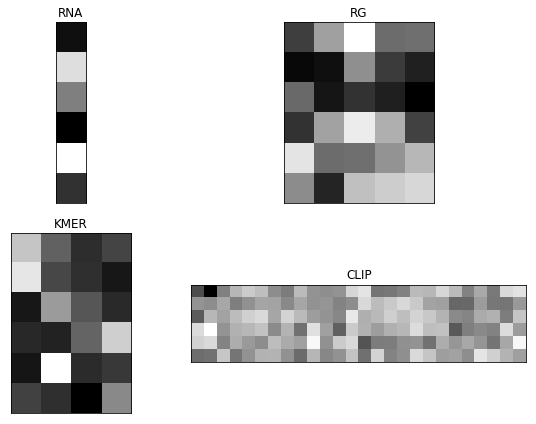

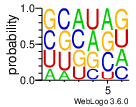

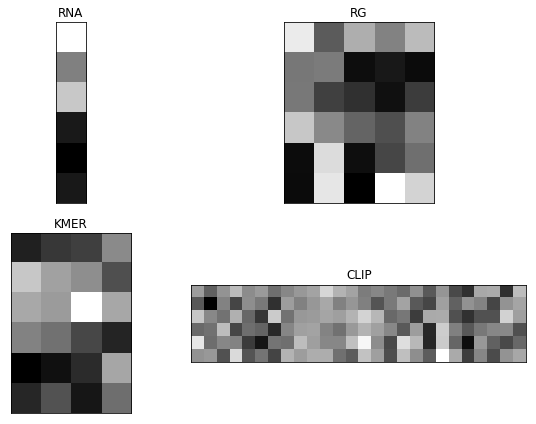

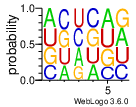

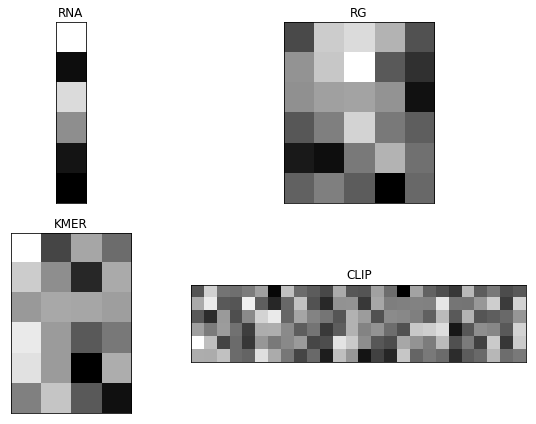

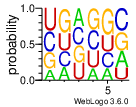

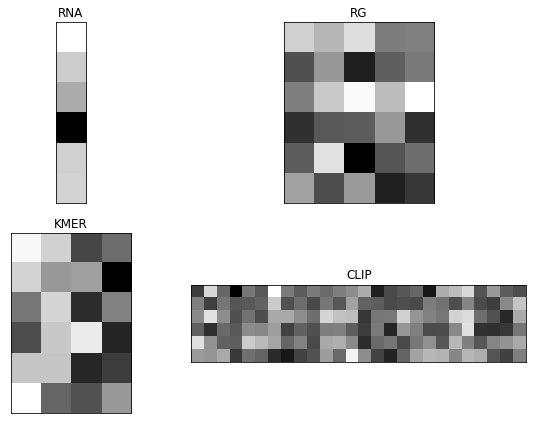

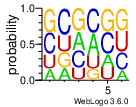

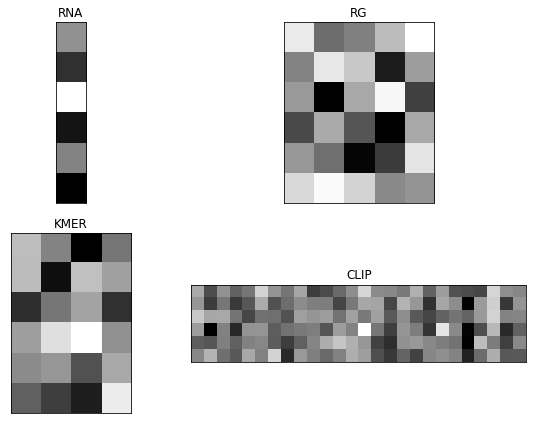

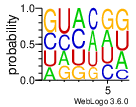

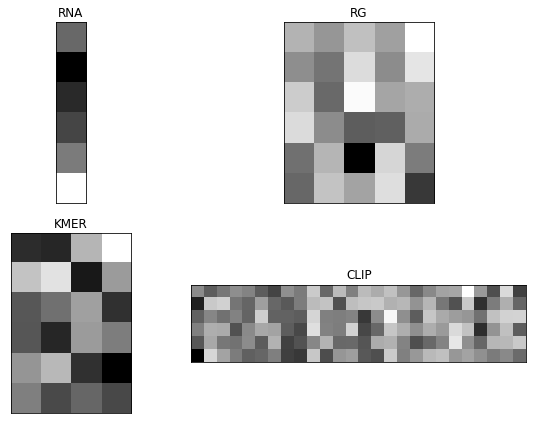

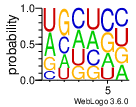

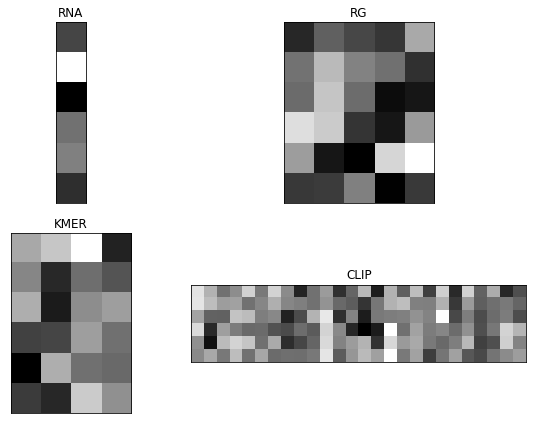

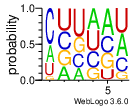

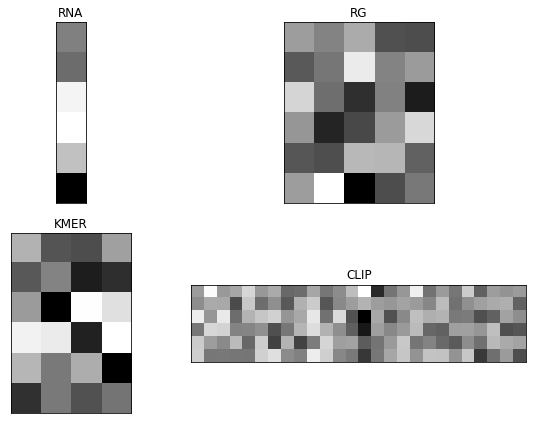

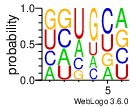

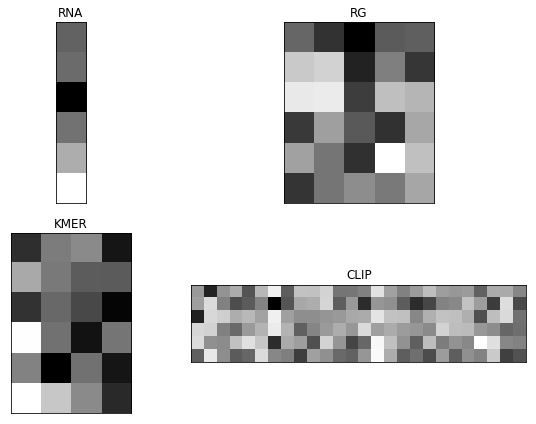

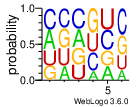

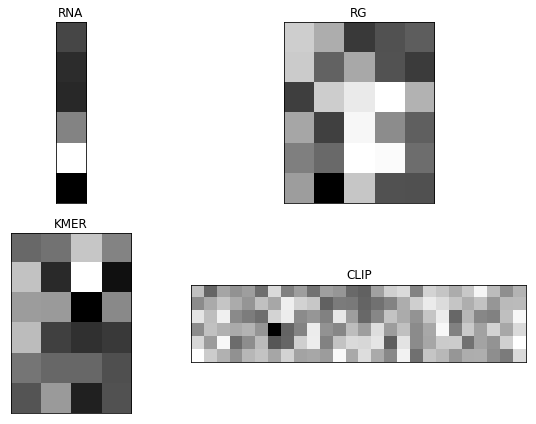

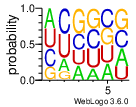

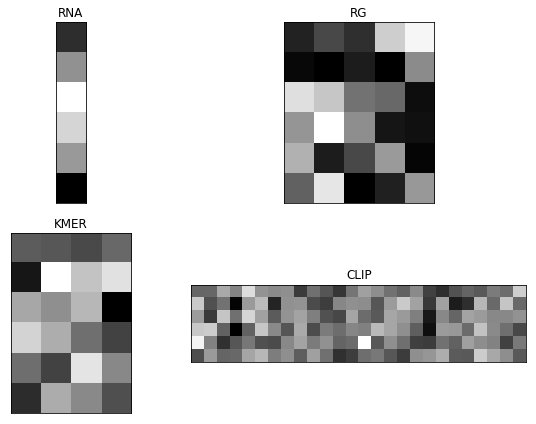

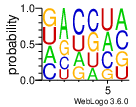

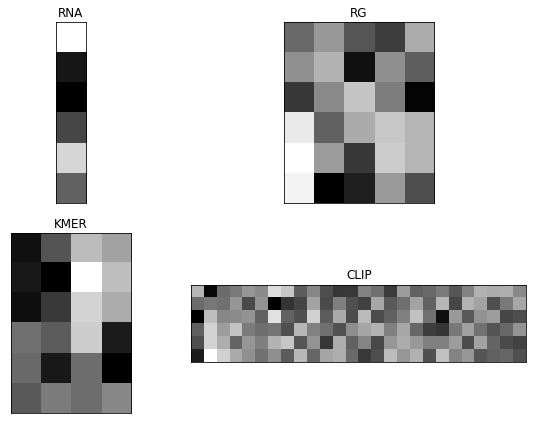

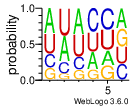

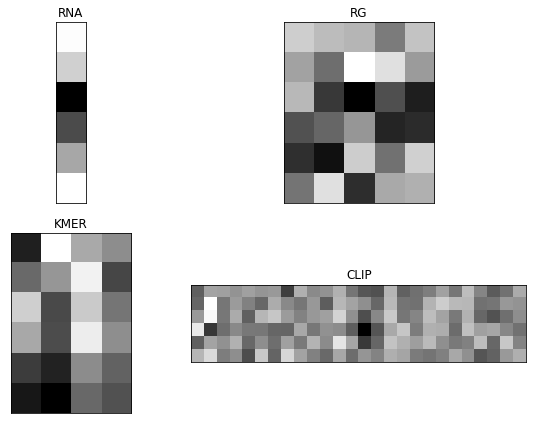

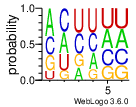

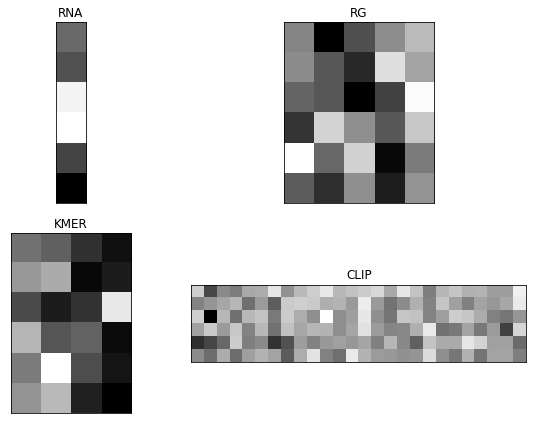

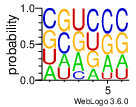

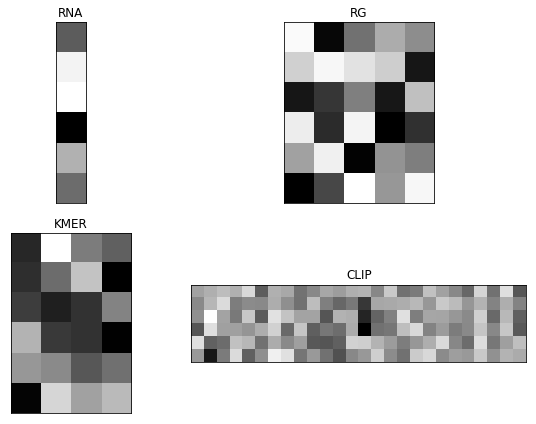

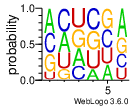

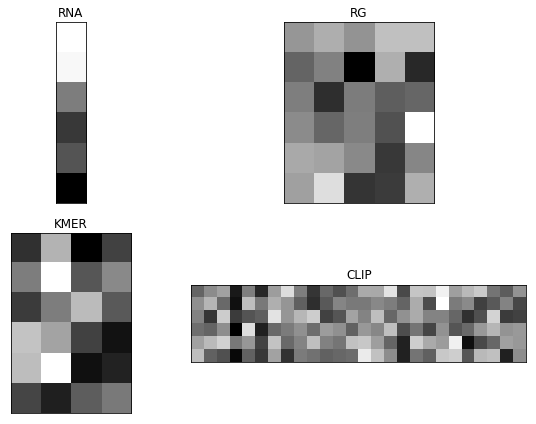

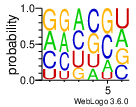

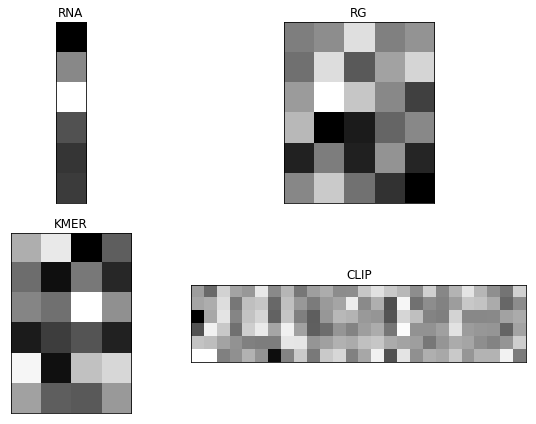

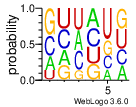

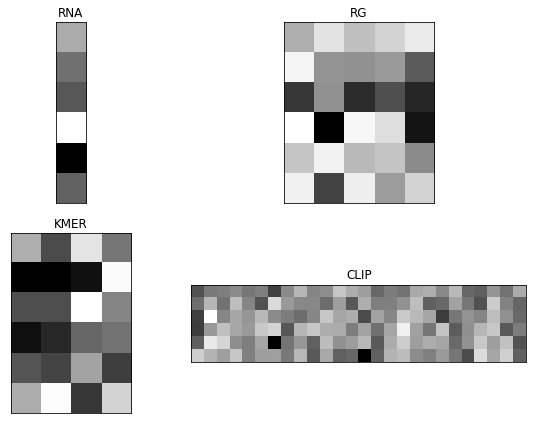

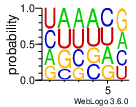

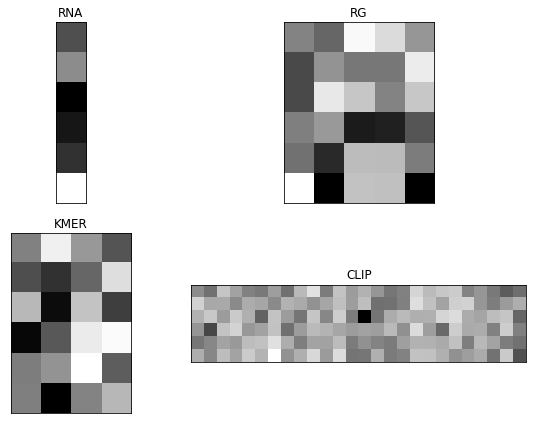

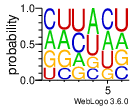

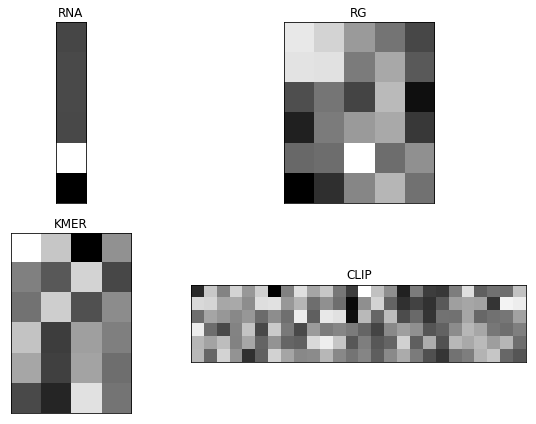

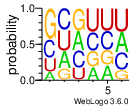

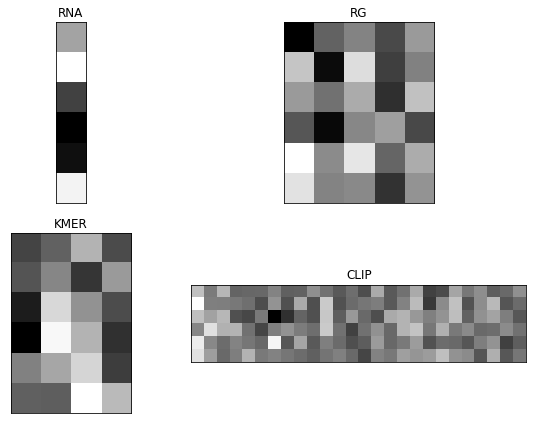

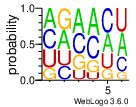

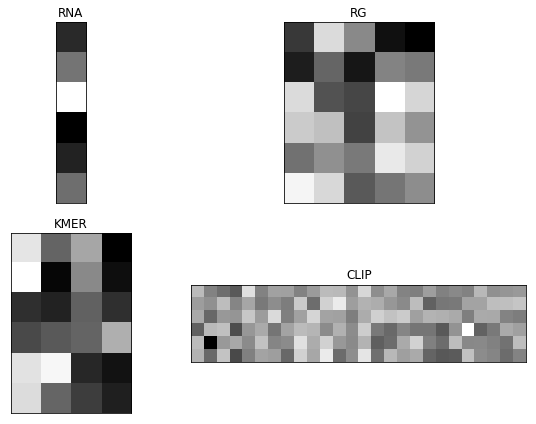

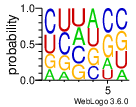

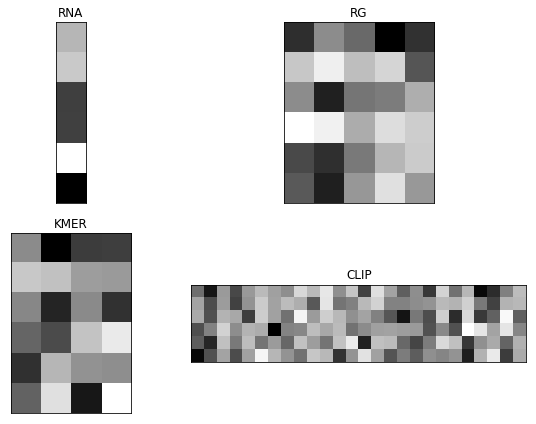

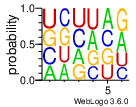

'\n RNA : probability of double stranded structure\n RG :exon, intron, 5\xe2\x80\x99UTR, 3\xe2\x80\x99UTR, CDS\n KMER : A, U, G, C\n CLIP \n'

In [13]:
from keras.models import model_from_json
from IPython.display import display, Image


protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            
            for f_index in range(filters.shape[2]):
                #plt.imshow(filters[:, :, f_index], cmap = 'jet')
                #plt.show()
                
                d_sources_filters = {'KMER': filters[:, 0:4 , f_index], 'RNA': filters[:, 4:5 , f_index], 'RG': filters[:, 5:10 , f_index], 'CLIP': filters[:, 10:36 , f_index]}
                fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 6),
                                        subplot_kw={'xticks': [], 'yticks': []})

                for ax, d_source in zip(axs.flat, d_sources_filters.keys()):
                    ax.imshow(d_sources_filters[d_source], cmap='binary')
                    ax.set_title(str(d_source))

                plt.tight_layout()
                plt.show()
                
                nucleotides = {'A' : filters[:, 0, f_index], 'T' : filters[:, 1, f_index], 'G' : filters[:, 2, f_index], 'C' : filters[:, 3, f_index]} 
                with open ("results/set_%s/%s/filters/filter_vis_%s.txt" % (training_set_number, protein, f_index), "w") as sequences_f:
                     sequences_f.write('P0 A U G C\n')

                for i in range (len(nucleotides['A'])):
                     with open ("results/set_%s/%s/filters/filter_vis_%s.txt" % (training_set_number, protein, f_index), "a") as sequences_f:
                        sequences_f.write('P{} {} {} {} {}\n'.format(i+1, nucleotides['A'][i], nucleotides['T'][i], nucleotides['G'][i], nucleotides['C'][i]))


        

                cmd = ("weblogo -f results/set_%s/%s/filters/filter_vis_%s.txt -D transfac -F png -o results/set_%s/%s/filters/filter_vis_%s.png -U probability --errorbars NO --show-xaxis YES --show-yaxis YES -A rna --composition none -n 6 --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U' " % (training_set_number, protein, f_index, training_set_number, protein, f_index)) 
                os.system(cmd)
                display(Image('results/set_%s/%s/filters/filter_vis_%s.png' % (training_set_number, protein, f_index)))
'''
 RNA : probability of double stranded structure
 RG :exon, intron, 5’UTR, 3’UTR, CDS
 KMER : A, U, G, C
 CLIP 
'''


1_PARCLIP_AGO1234_hg19
RNA


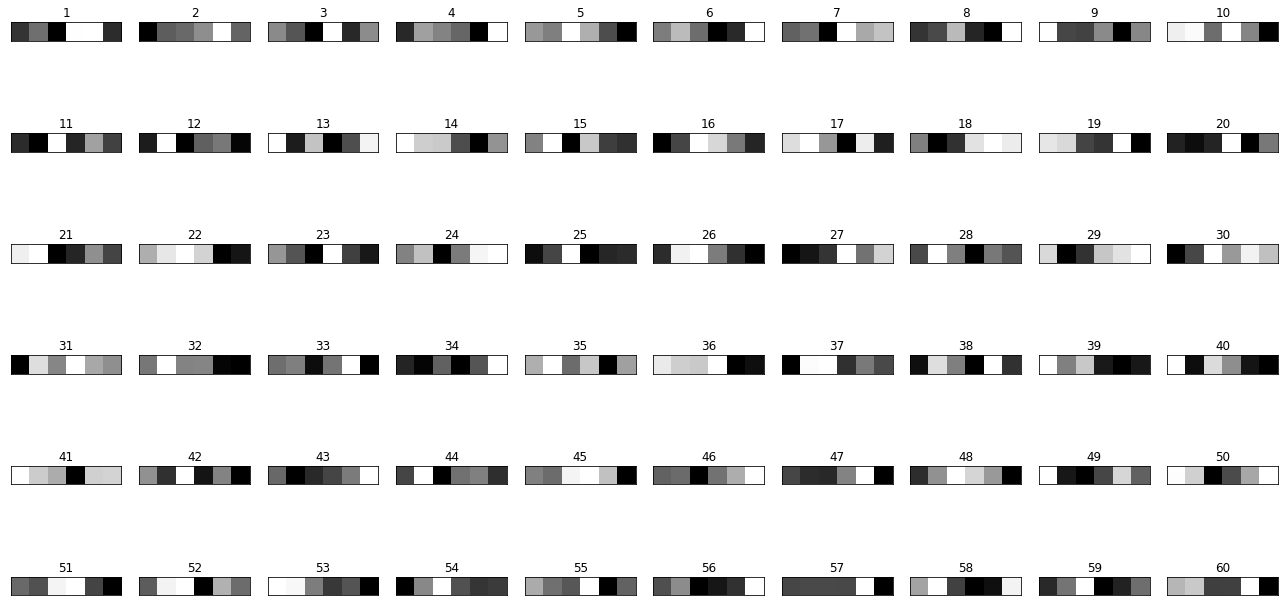

RG


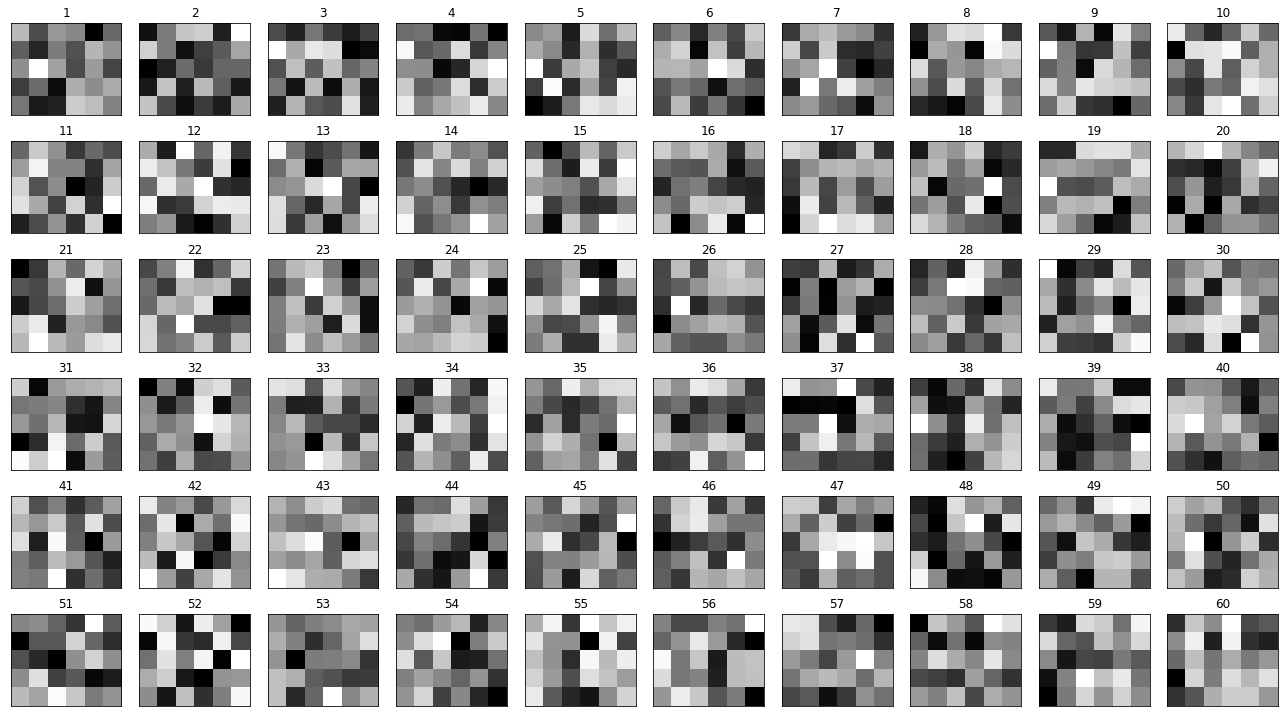

KMER


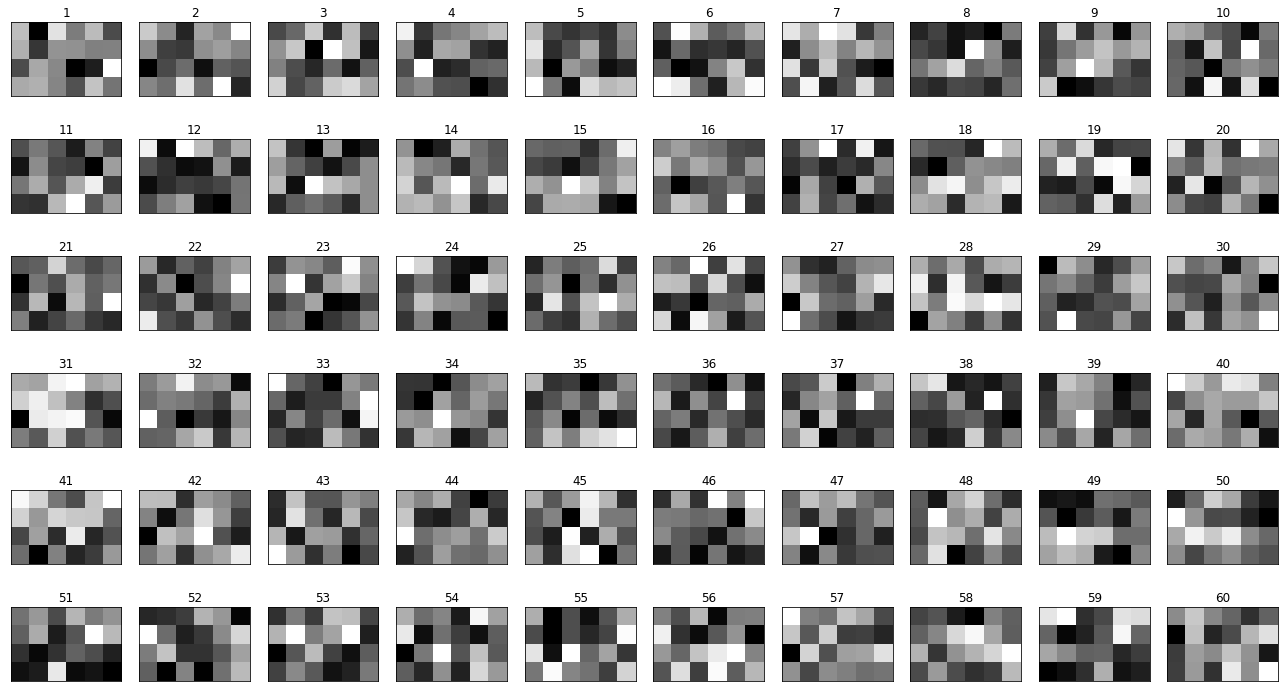

CLIP


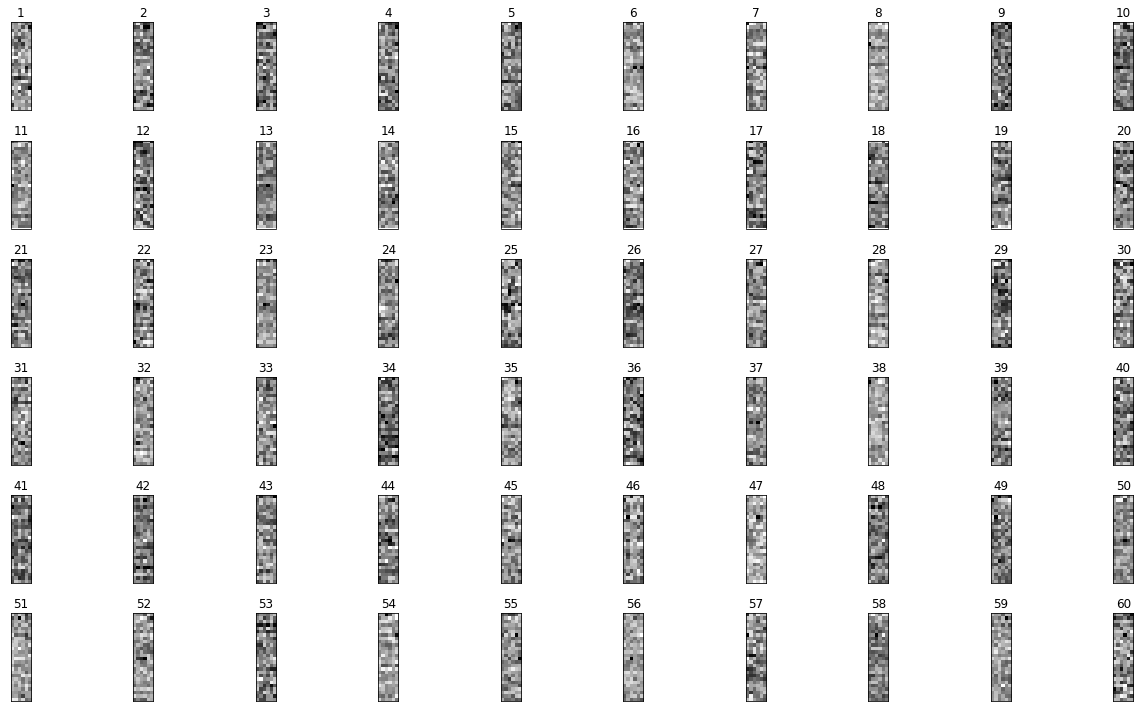

'\n RNA : probability of double stranded structure\n RG :exon, intron, 5\xe2\x80\x99UTR, 3\xe2\x80\x99UTR, CDS\n KMER : A, U, G, C\n CLIP \n'

In [15]:
from keras.models import model_from_json
from IPython.display import display, Image


protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            
            
            d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}
            
            
            for d_source in d_sources_filters.keys():
                print (d_source)
                fig, axs = plt.subplots(nrows = 6, ncols = 10, figsize=(18, 10),
                                            subplot_kw={'xticks': [], 'yticks': []})
                for ax, filter_num in zip(axs.flat, xrange(60)):
                        fil = (d_sources_filters[d_source])[:,:,filter_num]
                        ax.imshow(fil.T, cmap='binary')
                        ax.set_title(filter_num+1)

                plt.tight_layout()
                plt.show()
            
            
'''
 RNA : probability of double stranded structure
 RG :exon, intron, 5’UTR, 3’UTR, CDS
 KMER : A, U, G, C
 CLIP 
'''


1_PARCLIP_AGO1234_hg19
('RNA', (6, 1, 60))
(60, 6)


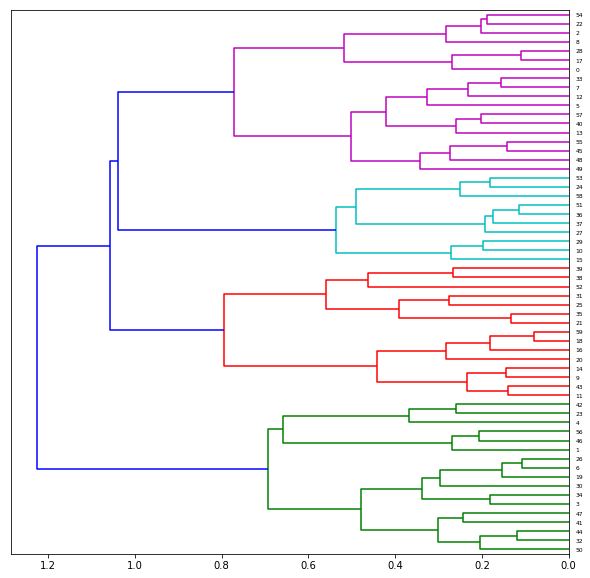

0.4153524657740263
('RG', (6, 5, 60))
(60, 30)


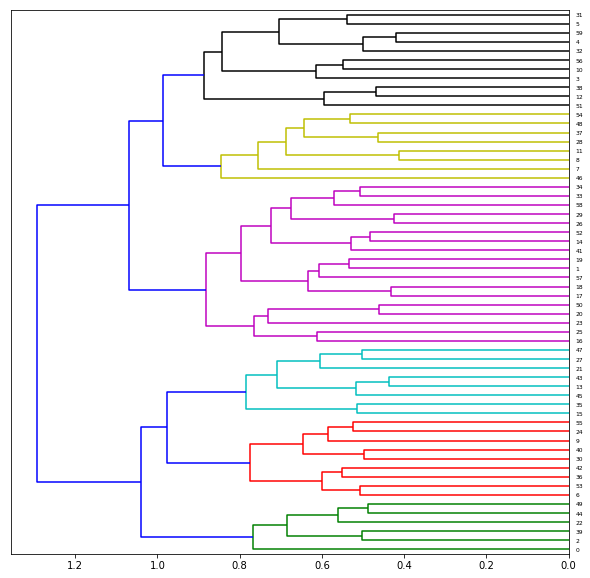

0.3345435502564731
('KMER', (6, 4, 60))
(60, 24)


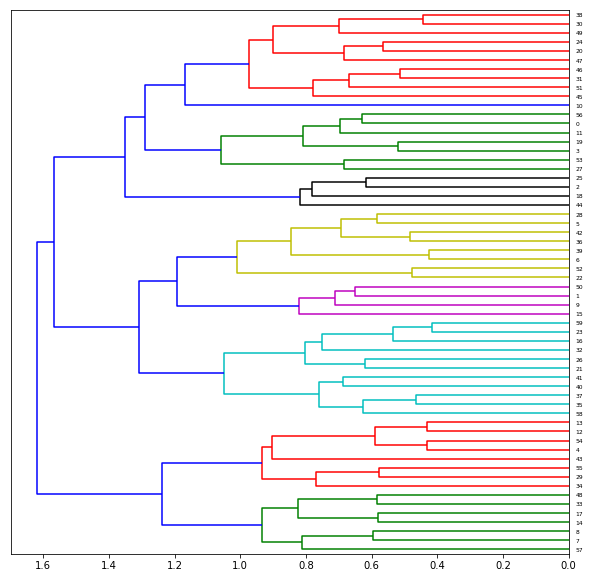

0.3467674318800691
('CLIP', (6, 26, 60))
(60, 156)


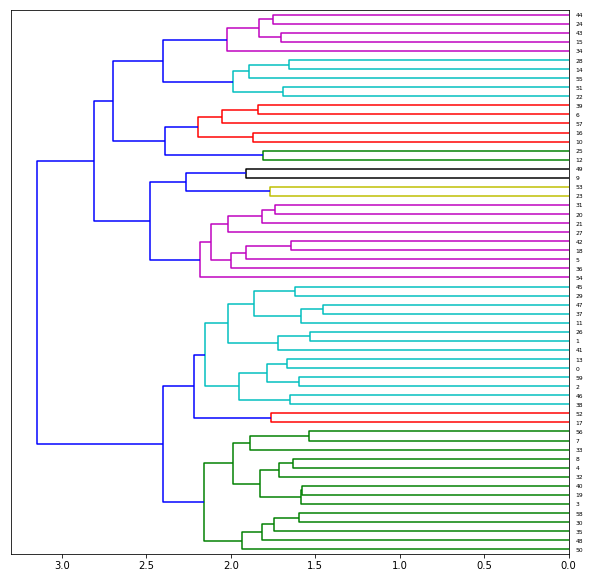

0.40949842508032236


In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from keras.models import model_from_json
import numpy as np
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            
            
            d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}
            
            
            for d_source in d_sources_filters.keys():
                print (d_source, d_sources_filters[d_source].shape) 
                #Create a array of observation vectors with dimensions [filter_number, flattened_filter]
                flat_source_arr = np.transpose(d_sources_filters[d_source].reshape(-1,d_sources_filters[d_source].shape[-1]))
                print (flat_source_arr.shape)
                Z = linkage(flat_source_arr, 'ward')
                fig = plt.figure(figsize=(10, 10))
                dn = dendrogram(Z, orientation = 'left')
                plt.show()
                
                
                #Calculate cophenetic correlation.
                c, coph_dists = cophenet(Z, pdist(flat_source_arr))
                print (c)

1_PARCLIP_AGO1234_hg19
('RNA', (6, 1, 60))
(60, 6)
('RG', (6, 5, 60))
(60, 30)
('KMER', (6, 4, 60))
(60, 24)
('CLIP', (6, 26, 60))
(60, 156)


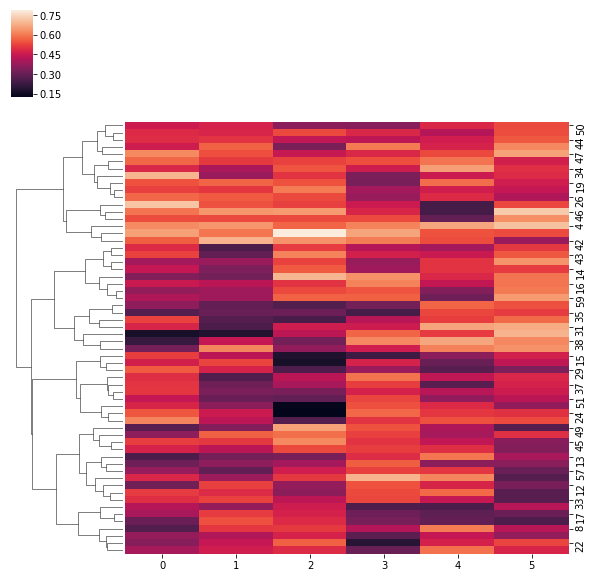

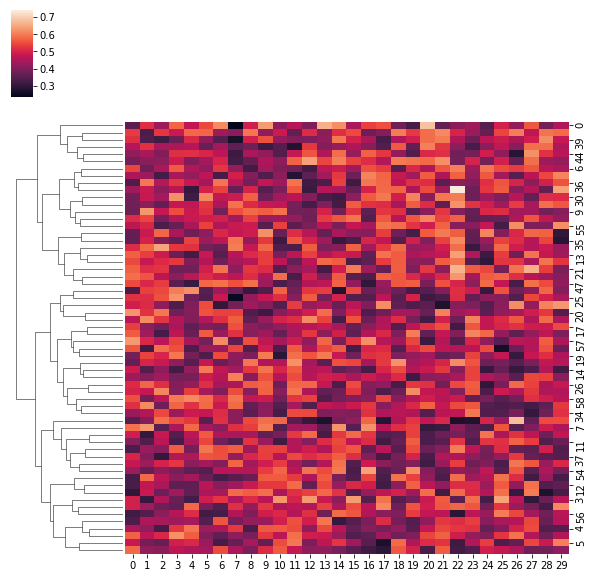

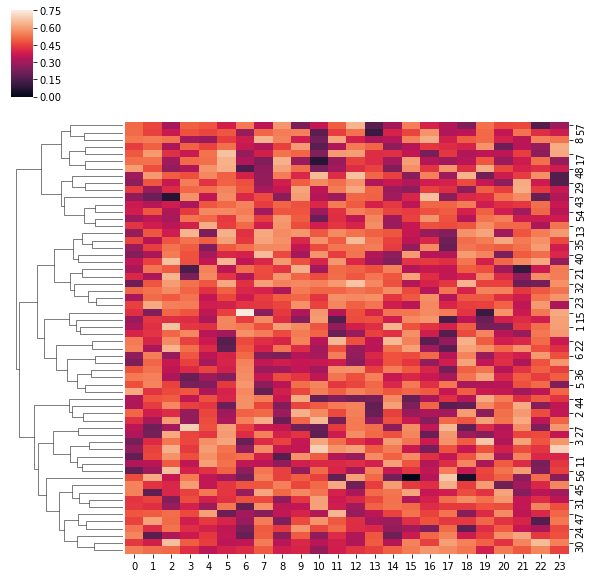

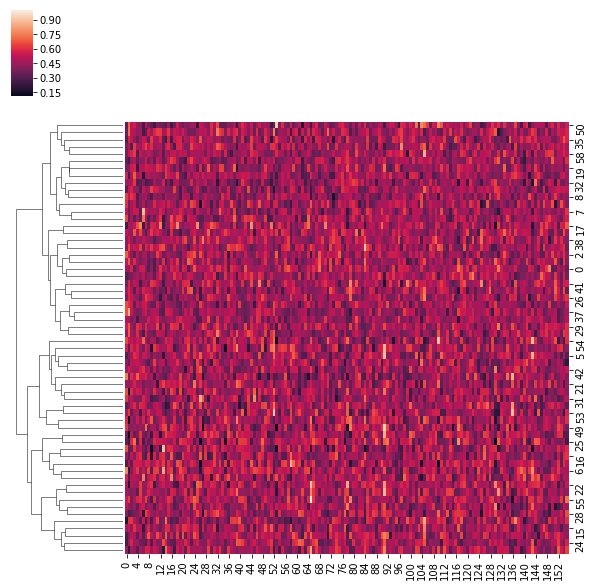

In [11]:
#installed seaborn
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from keras.models import model_from_json
import numpy as np
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            
            
            d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}
            
            for d_source in d_sources_filters.keys():
                print (d_source, d_sources_filters[d_source].shape) 
                #Create a array of observation vectors with dimensions [filter_number, flattened_filter]
                flat_source_arr = np.transpose(d_sources_filters[d_source].reshape(-1,d_sources_filters[d_source].shape[-1]))
                print (flat_source_arr.shape)
                g = sns.clustermap(flat_source_arr, method = 'ward', col_cluster = False)

Using TensorFlow backend.


1_PARCLIP_AGO1234_hg19
(30000, 101, 36)
0.932554375
RNA
('RNA', (6, 1, 10))
(10, 6)


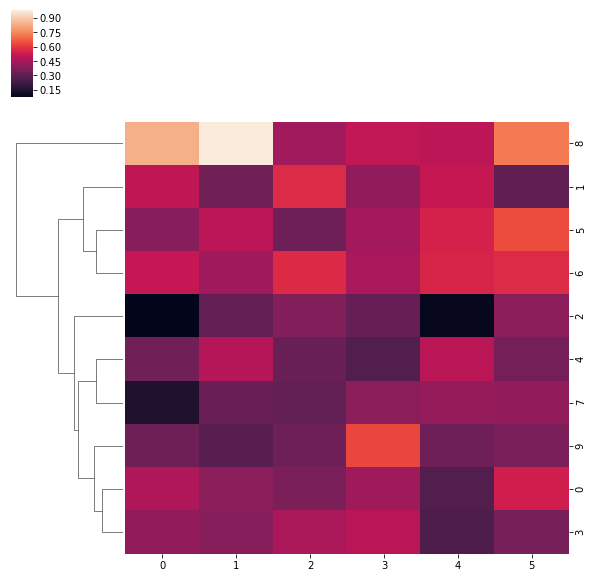

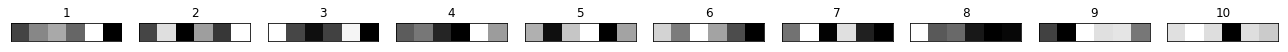

RG
('RG', (6, 5, 10))
(10, 30)


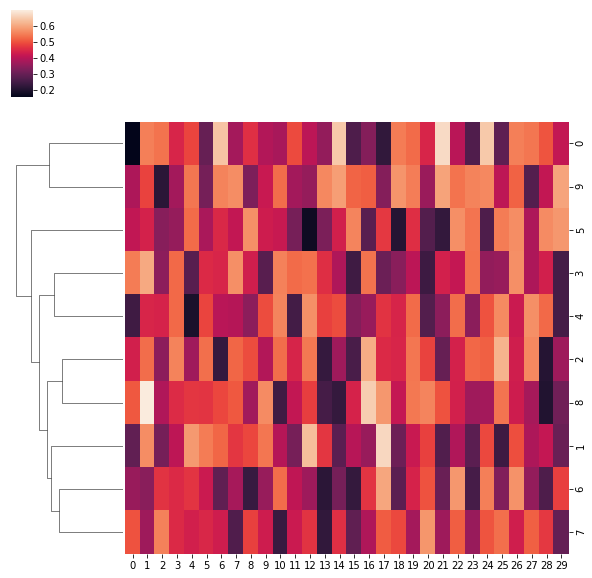

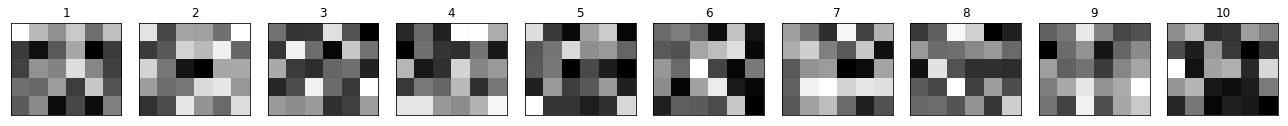

KMER
('KMER', (6, 4, 10))
(10, 24)


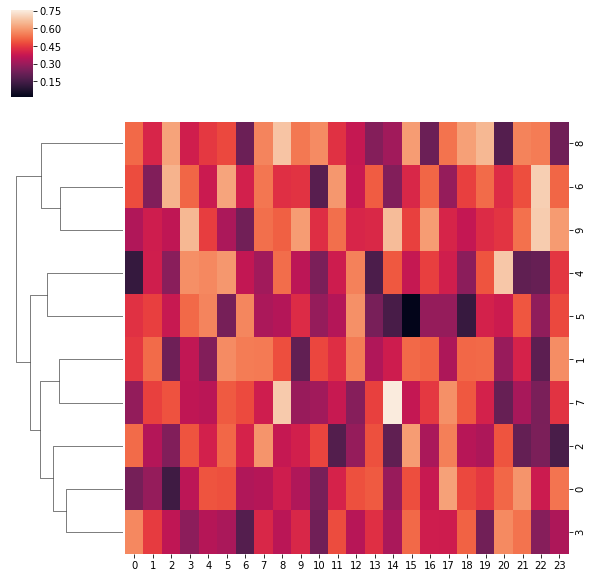

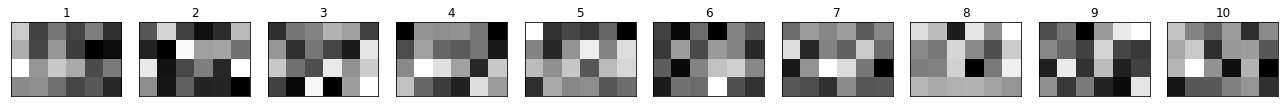

CLIP
('CLIP', (6, 26, 10))
(10, 156)


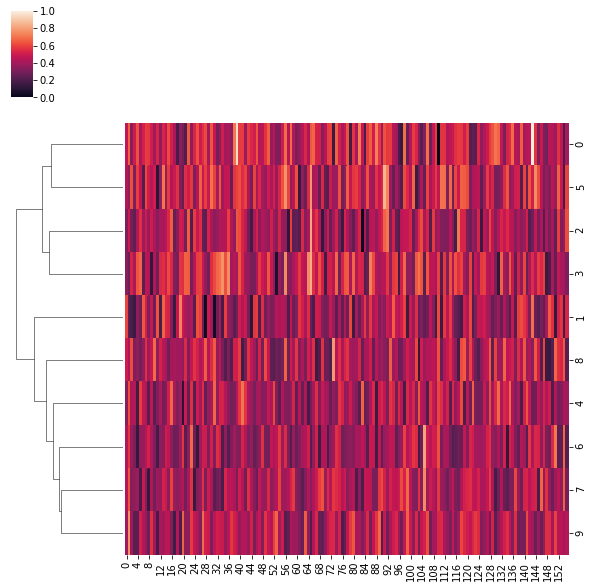

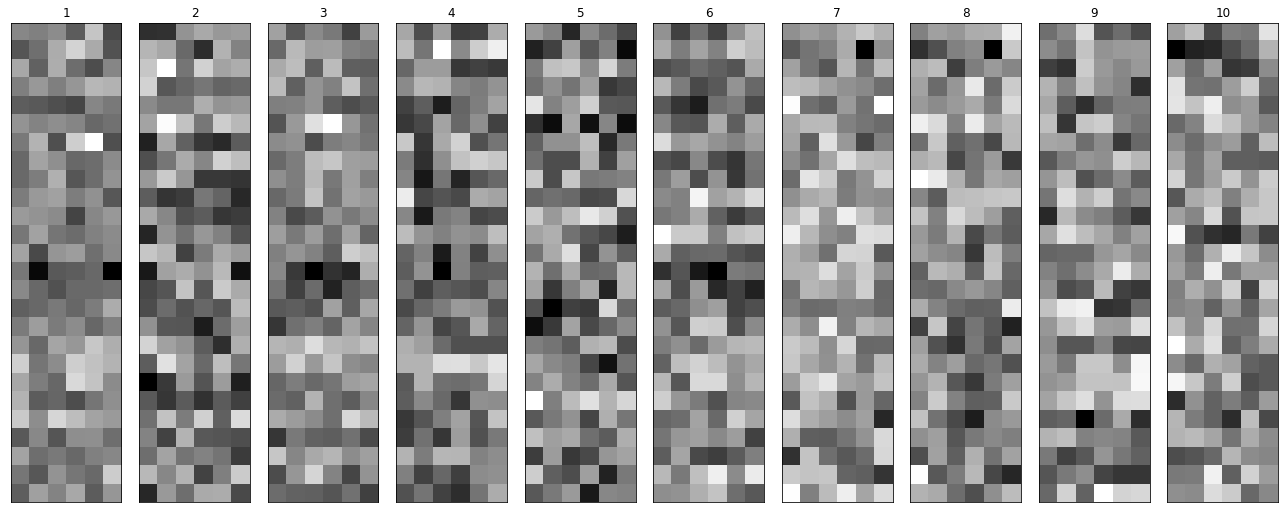

2_PARCLIP_AGO2MNASE_hg19
(30000, 101, 36)
0.74392096875
RNA
('RNA', (6, 1, 10))
(10, 6)


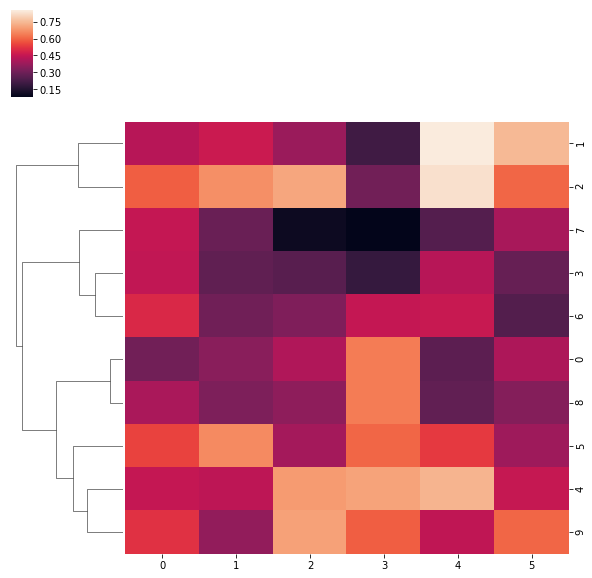

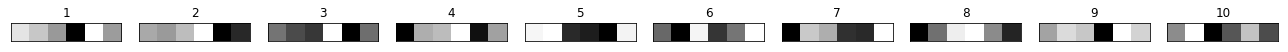

RG
('RG', (6, 5, 10))
(10, 30)


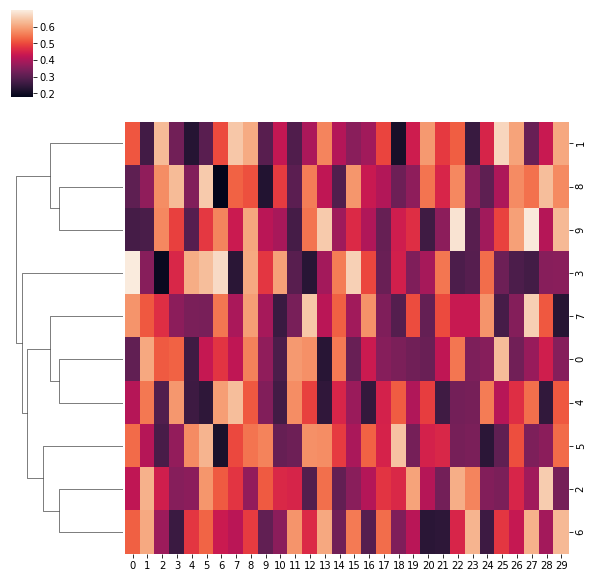

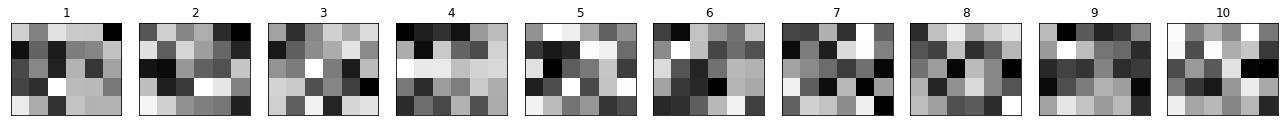

KMER
('KMER', (6, 4, 10))
(10, 24)


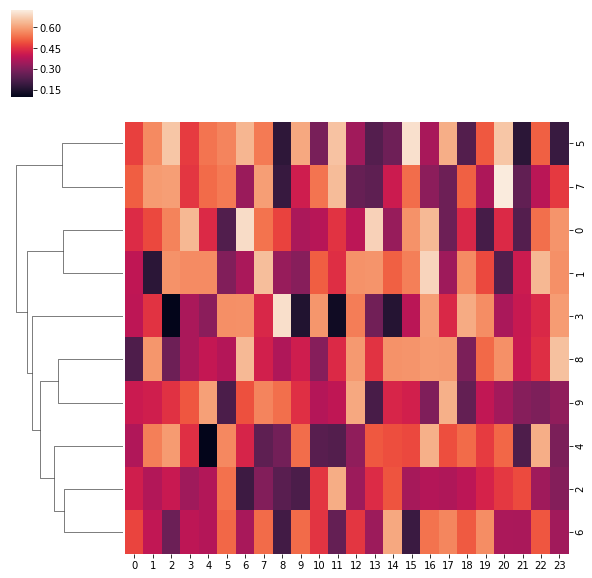

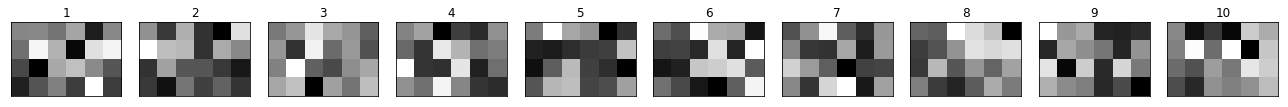

CLIP
('CLIP', (6, 26, 10))
(10, 156)


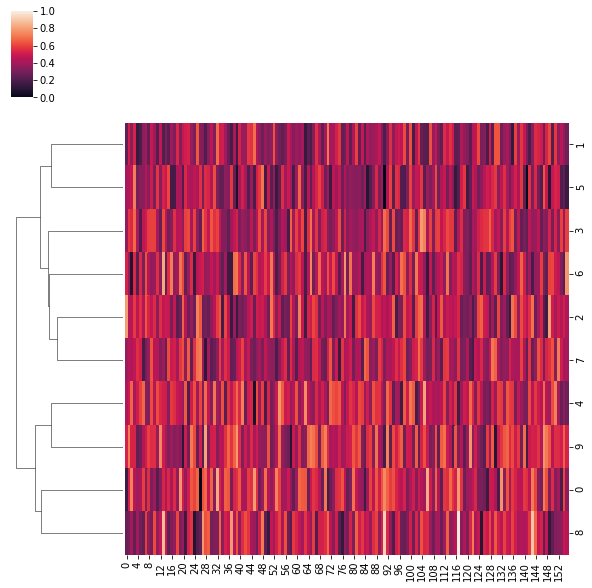

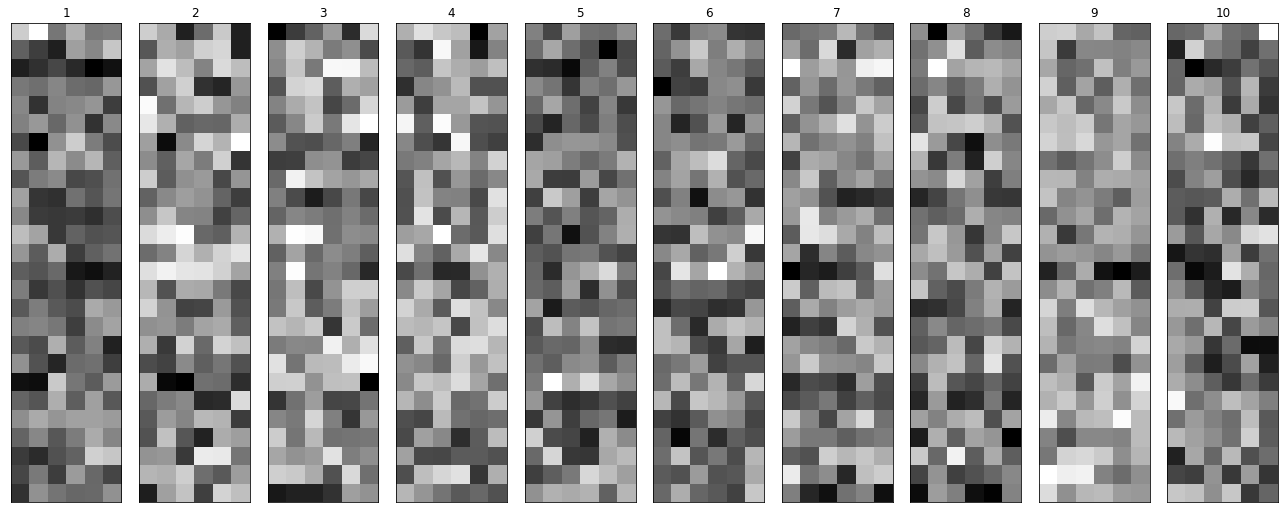

3_HITSCLIP_Ago2_binding_clusters
(30000, 101, 36)
0.93982071875
RNA
('RNA', (6, 1, 10))
(10, 6)


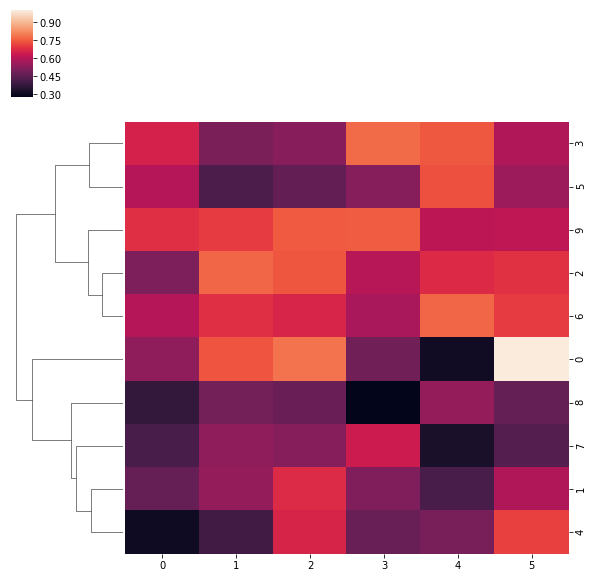

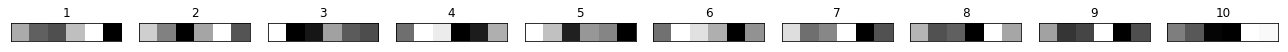

RG
('RG', (6, 5, 10))
(10, 30)


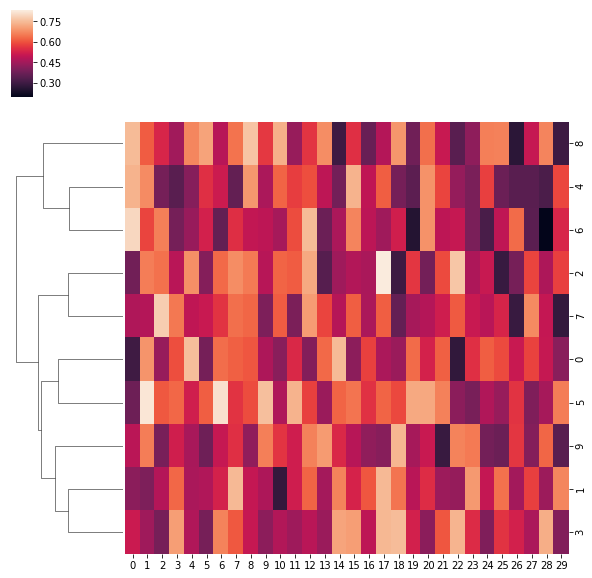

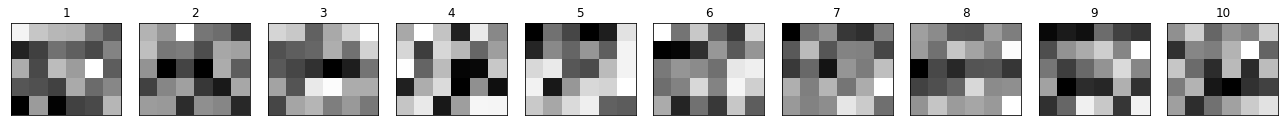

KMER
('KMER', (6, 4, 10))
(10, 24)


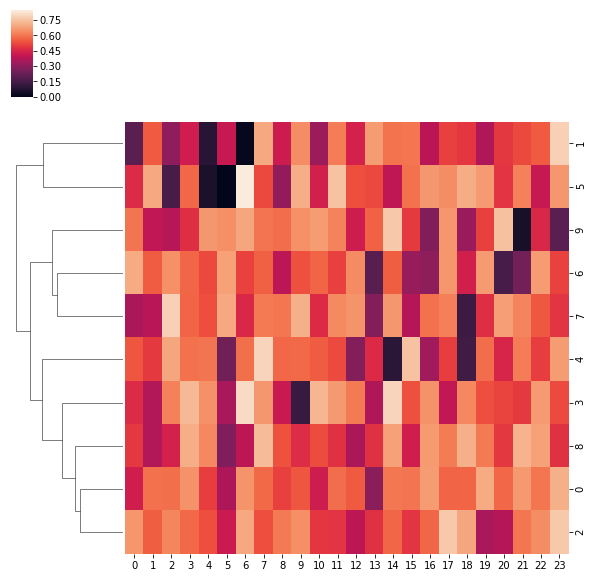

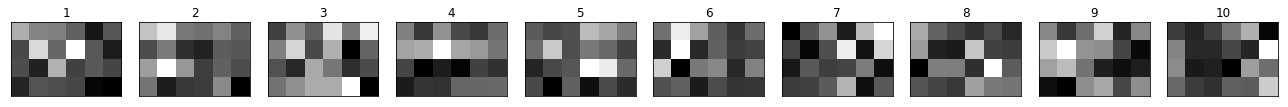

CLIP
('CLIP', (6, 26, 10))
(10, 156)


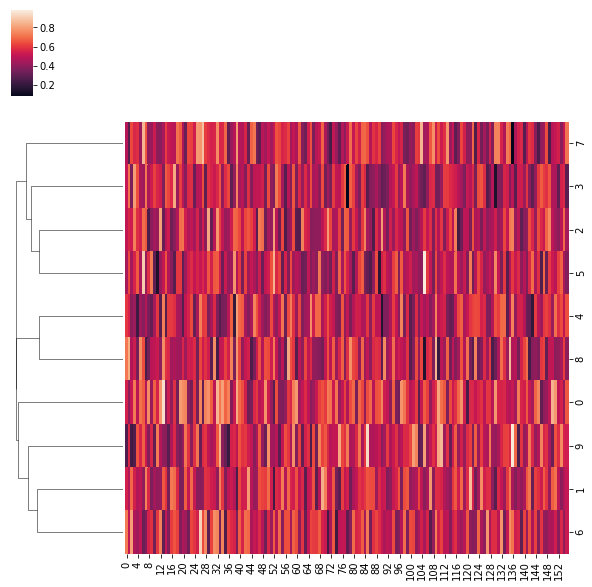

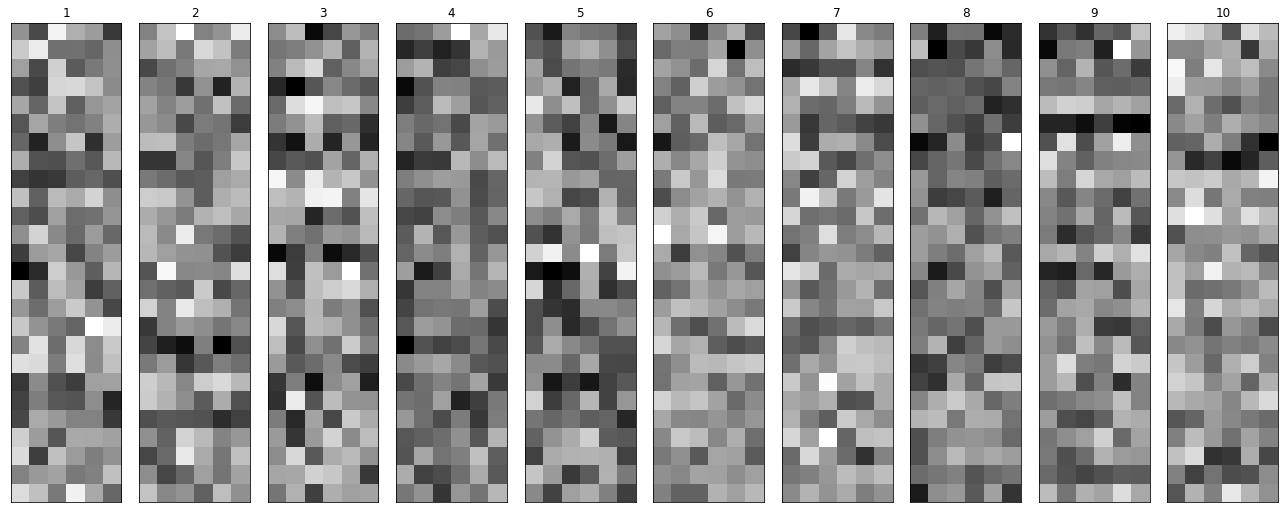

4_HITSCLIP_Ago2_binding_clusters_2
(30000, 101, 36)
0.9392662187499999
RNA
('RNA', (6, 1, 10))
(10, 6)


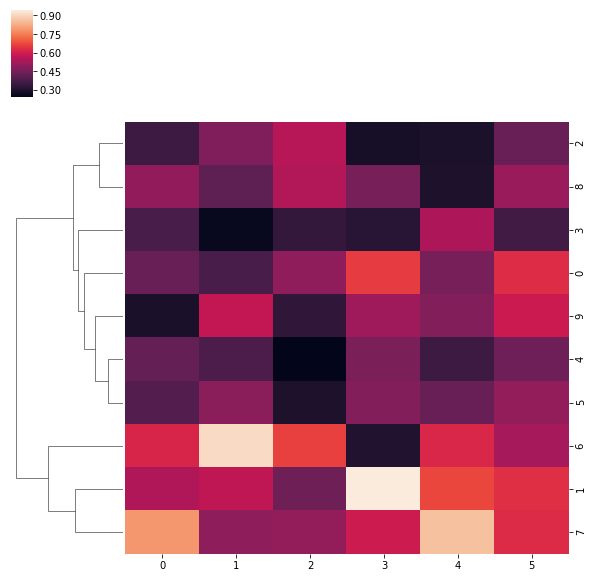

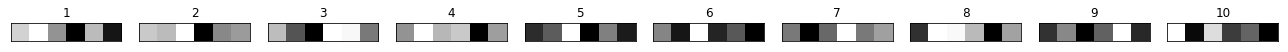

RG
('RG', (6, 5, 10))
(10, 30)


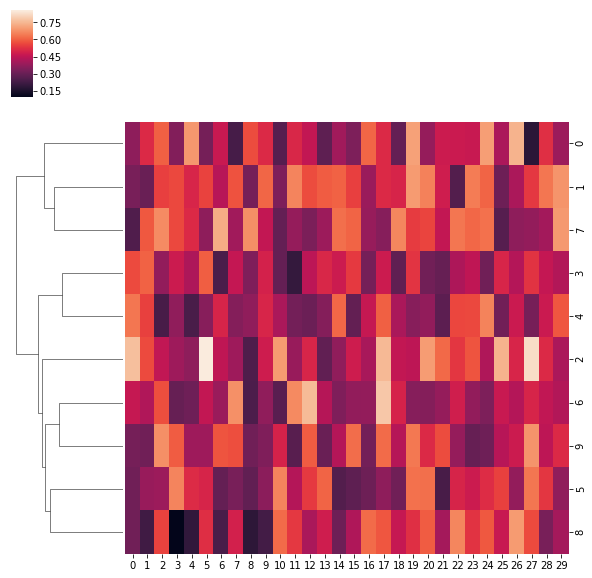

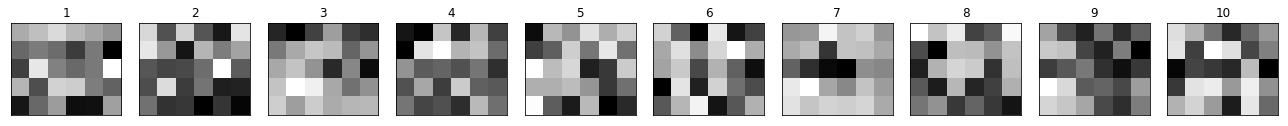

KMER
('KMER', (6, 4, 10))
(10, 24)


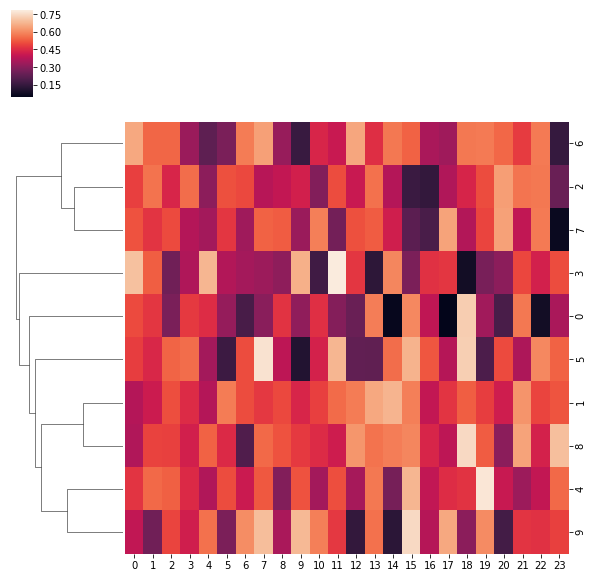

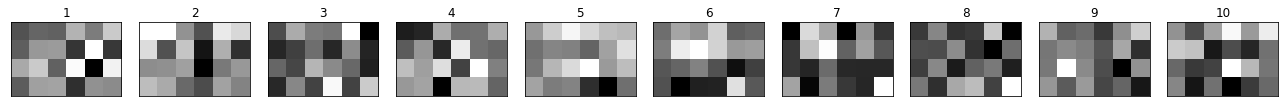

CLIP
('CLIP', (6, 26, 10))
(10, 156)


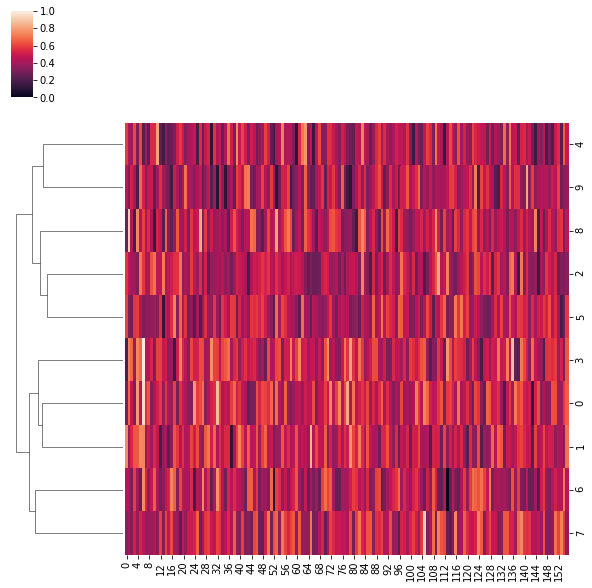

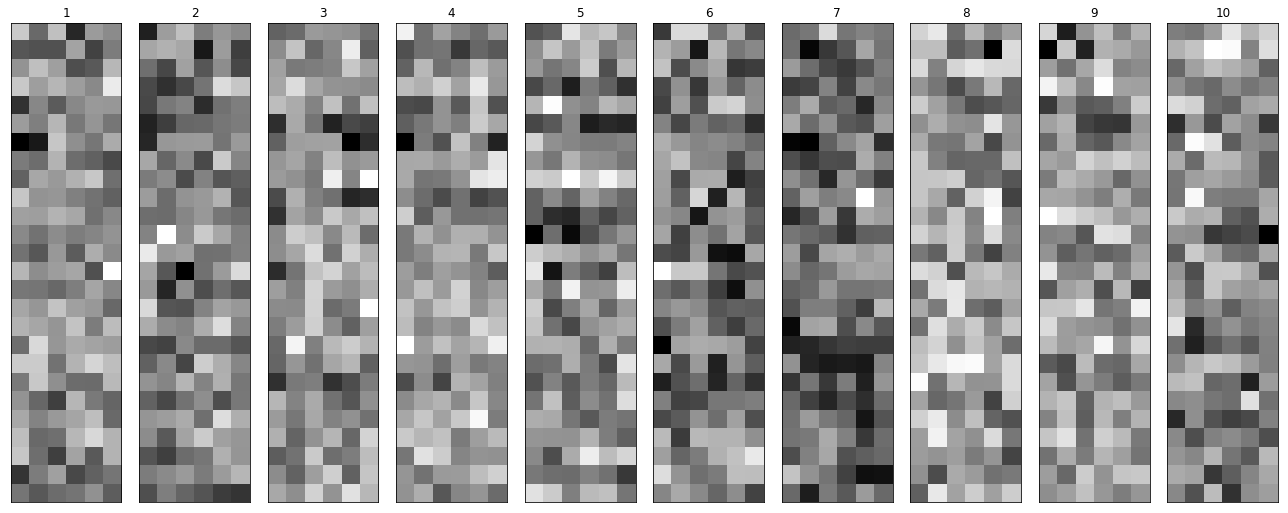

5_CLIPSEQ_AGO2_hg19
(30000, 101, 36)
0.7687440312500001
RNA
('RNA', (6, 1, 10))
(10, 6)


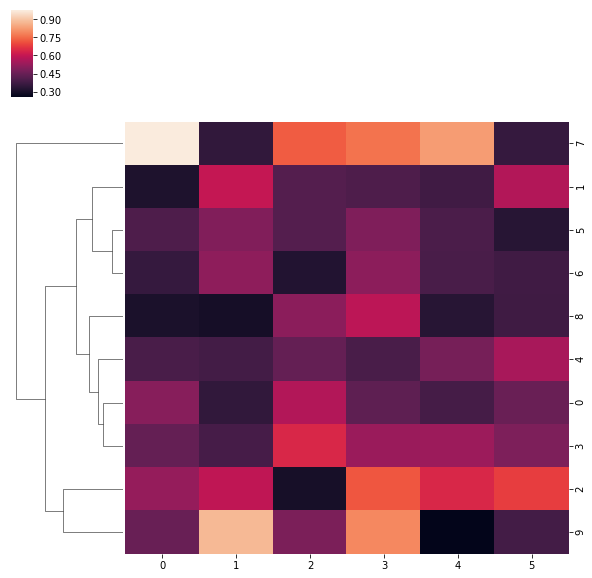

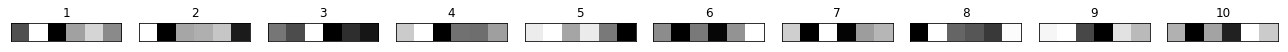

RG
('RG', (6, 5, 10))
(10, 30)


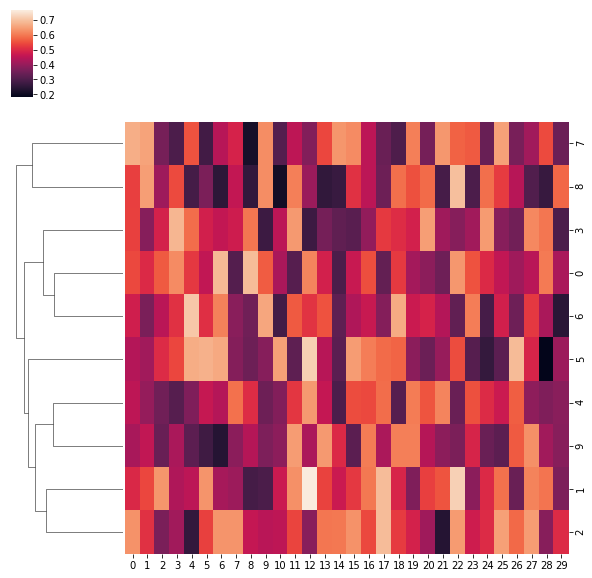

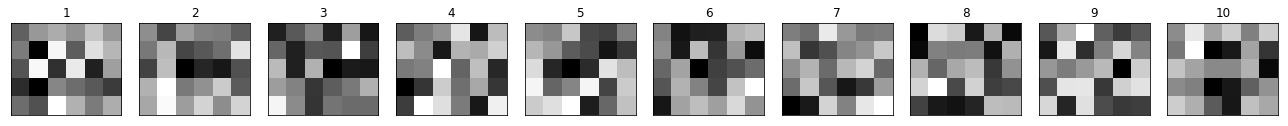

KMER
('KMER', (6, 4, 10))
(10, 24)


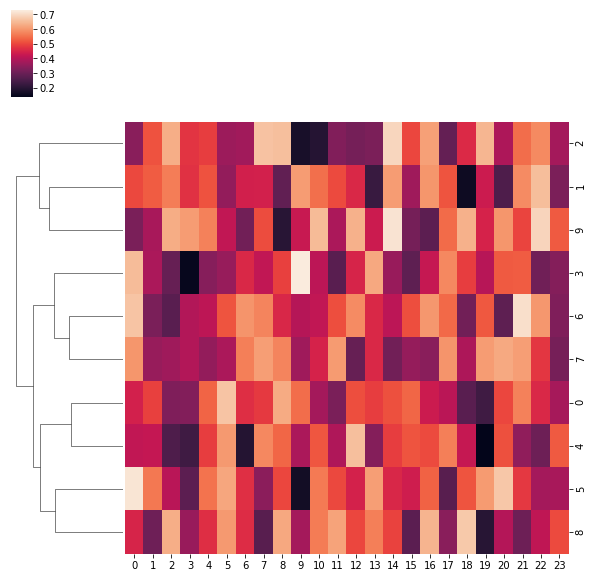

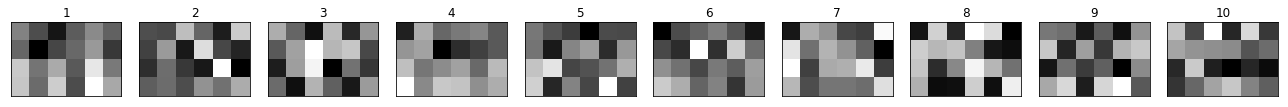

CLIP
('CLIP', (6, 26, 10))
(10, 156)


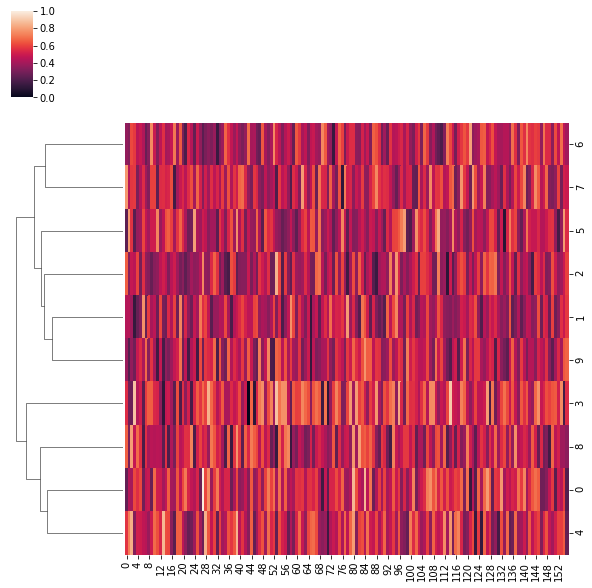

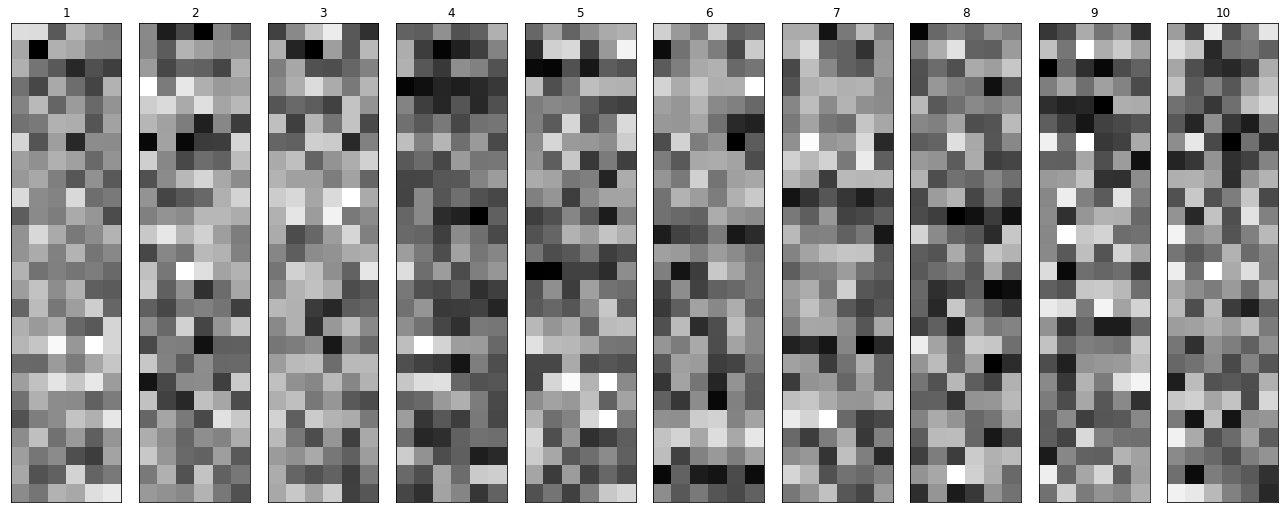

In [1]:
#30k datasets 
%matplotlib inline 

import numpy as np
from Bio import SeqIO
import gzip
import os
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



np.random.seed(454)


def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X




protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19"]#, "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
average_score = np.zeros(len(protein_list))
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


for training_set_number in range (1):
        
    score_list = []
    
    for protein in protein_list:

        print (protein)

        data_sources, X = load_data_sources(protein, 'train', training_set_number, *experiment_set)
        y = get_class(protein,"train",training_set_number)
        print (X.shape)
        size = X.shape[2]
        score = []
        
        model = Sequential()
        model.add(Conv1D(10,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
        model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
        model.add(Conv1D(10, 4, activation='relu'))
        model.add(Dropout(0.1))
        model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
        model.add(Conv1D(15, 4, activation='relu'))
        model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
        model.add(Conv1D(15, 3, activation='relu'))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(2, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/" + protein + "_weights.hdf5", verbose=0, save_best_only=True)
        earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        X_train = X
        y_train = y

        metrics = model.fit(X_train, y_train, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

        
        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)
        y_test = get_class(protein,"test",training_set_number)
        
        #Run predictions on test dataset.
        y_scores = model.predict(X_test)
        y_scores = y_scores [:,0:1]
        y_test = y_test [:,0:1]

        score = roc_auc_score(y_test, y_scores)
        print (score)

        filters, biases = model.layers[0].get_weights()
            
        filter_min, filter_max = filters.min(), filters.max()
        #normalize filter values
        filters = (filters - filter_min) / (filter_max - filter_min)


        d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}


        for d_source in d_sources_filters.keys():
            print (d_source)
            
            print (d_source, d_sources_filters[d_source].shape) 
            #Create a array of observation vectors with dimensions [filter_number, flattened_filter]
            flat_source_arr = np.transpose(d_sources_filters[d_source].reshape(-1,d_sources_filters[d_source].shape[-1]))
            print (flat_source_arr.shape)
            g = sns.clustermap(flat_source_arr, method = 'ward', col_cluster = False)
            
            fig, axs = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 10),
                                        subplot_kw={'xticks': [], 'yticks': []})
            for ax, filter_num in zip(axs.flat, xrange(10)):
                    fil = (d_sources_filters[d_source])[:,:,filter_num]
                    ax.imshow(fil.T, cmap='binary')
                    ax.set_title(filter_num+1)

            plt.tight_layout()
            plt.show()
        plt.close()